# Multi-Layer Perceptron, MNIST

### import libraries

In [1]:
import torch
import numpy as np


## Load and Visualize the Data

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
## TODO: set number of samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Visualize a Batch of Training Data

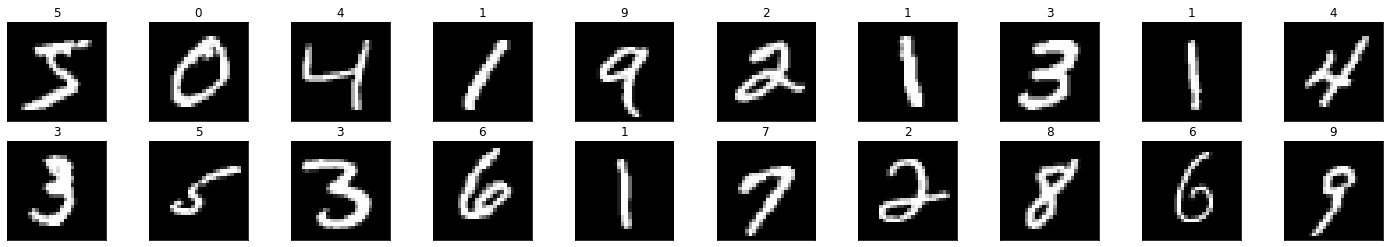

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))


### View an Image in More Detail

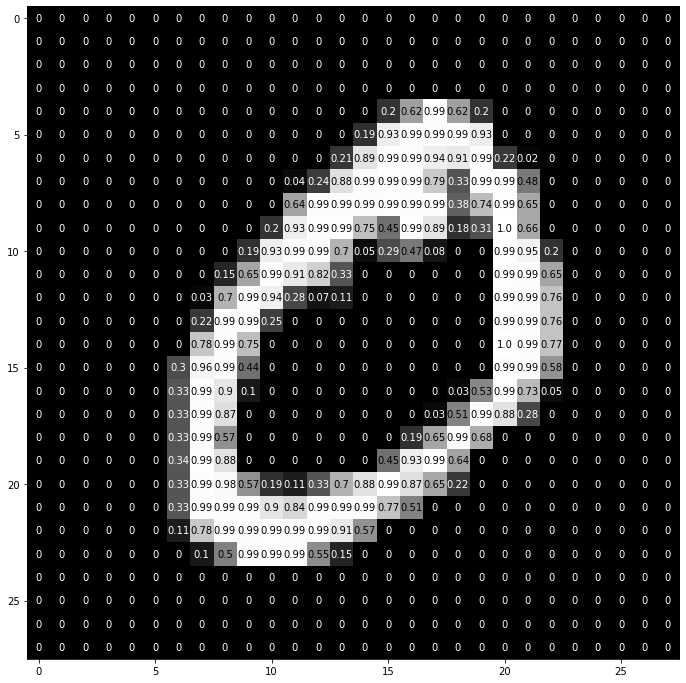

In [4]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')


## Define the Network Architecture

In [5]:
import torch.nn as nn
import torch.nn.functional as F

## TODO: Define the NN architecture
# different activation functions: relu, sigmoid, tanh

class Net(nn.Module):
    def __init__(self, in_features=28*28, hidden=[512, 128], num_classes=10, activation='relu', criterion='cross-entropy'):
        super().__init__() 
        self.criterion = criterion

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features, hidden[0])

        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else: self.activation = nn.ReLU()

        self.linear2 = nn.Linear(hidden[0], hidden[1])
        self.dropout = nn.Dropout(0.2)
        self.linear3 = nn.Linear(hidden[1], num_classes)

    def forward(self, x):
        out = self.flatten(x)
        out = self.activation(self.linear1(out))
        out = self.dropout(out)
        out = self.activation(self.linear2(out))
        out = self.dropout(out)
        out = self.linear3(out)
        
        # apply logsoftmax when using nll as loss
        if self.criterion == 'nll':
            out = F.log_softmax(out, dim=-1)

        return out


## Train the Network


In [6]:
from torch import optim

## TODO:
###############################################
#               train the model               #
###############################################

# different loss functions: cross-entropy, negative log likelihood
# different optimizers: sgd, adam, rms-prop

def train(model, train_loader, criterion, my_optimizer, learning_rate=0.01, num_epochs=15):

    ## TODO: specify optimizer
    if my_optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif my_optimizer == 'rms-prop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    else: optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    ## TODO: specify loss function
    loss_fn = nn.NLLLoss() if criterion == 'nll' else nn.CrossEntropyLoss()

    losses = []
    accuracies = []    

    size = len(train_loader.dataset)
    # training
    for epoch in range(num_epochs):

        # iterate on batches
        print("Epoch", epoch)
        epoch_loss = 0
        correct = 0

        model.train()
        for batch, (x, y) in enumerate(train_loader):
           
            # forward propagation
            pred = model(x)
            # calculate loss
            loss = loss_fn(pred, y)
            # loss.item() gives the average loss of the batch
            # so multiply it by batch size to get the sum
            epoch_loss +=  pred.shape[0] * loss.item()

            # backward propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 300 == 0:
                loss, current = loss.item(), (batch + 1) * len(x)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

            # calculate accuracy
            pred_classes = torch.argmax(pred, dim=1)
            correct += (pred_classes == y).float().sum()

        epoch_loss /= size
        correct = correct * 100 / size

        print(f"epoch loss: {epoch_loss:.4f}")
        print(f"epoch accuracy: {correct:.4f}")
        
        losses.append(epoch_loss)
        accuracies.append(correct)

        print("*"*25)

    return losses, accuracies

In [7]:
def plot(losses, accuracies, batch_size=64, learning_rate=0.01):
    # plotting
    plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
    plt.plot(losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
    plt.plot(accuracies, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

## Predict with Trained Network



In [8]:
## TODO:
###############################################
#               test the model                #
###############################################

def predict(model, test_loader, criterion):

    loss_fn = nn.NLLLoss() if criterion == 'nll' else nn.CrossEntropyLoss()
    with torch.no_grad():
        predictions = []
        ## TODO: calculate and print avg test loss
        loss = 0

        for data in test_loader:
            images, labels = data
            pred = model(images)
            loss += pred.shape[0] * loss_fn(pred, labels).item()

            pred_classes = torch.argmax(pred, dim=1)
            predictions.append(pred_classes)

        loss /= len(test_loader.dataset)
        print('Test Loss: {:.6f}\n'.format(loss))
        
    return torch.cat(predictions)

### Visualize Sample Test Results

In [9]:
import matplotlib.pyplot as plt

def visualize(model, test_loader):
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # get sample outputs
    output = model(images)
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    # prep images for display
    images = images.numpy()

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 30))
    for idx in np.arange(20):
        ax = fig.add_subplot(5, 20//4, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                    color=("green" if preds[idx]==labels[idx] else "red"), fontsize=20)

## evaluation metrics

#### Calculate Accuracy, Confusion Matrix, f1_score for each class

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_curve, auc

def metrics(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy:', accuracy)
    print()

    confusion = confusion_matrix(y_test, y_pred)
    print('confusion matrix:')
    print(confusion)
    print()

    f1_score_list = f1_score(y_test, y_pred, average=None)
    for i, f1 in enumerate(f1_score_list):
        print('f1_score for class {} is: {}'.format(i, f1))
    print()

### Calculate the AUC and ROC

##### Calculate the AUC and ROC for each class and then average

In [11]:
import pandas as pd
from sklearn.preprocessing import label_binarize
from scipy import interp

def roc(y_pred, y_test):
    y_score = []
    for x in y_pred:
        temp = [0]*10
        temp[x] = 1
        y_score.append(temp)
    y_score_df = pd.DataFrame(y_score)
    y_score_df= y_score_df.fillna(0)
    y_score = y_score_df.to_numpy()
    print(y_score)
    print()

    n_classes = 10
    y_test_binery = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binery[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    for i in range(n_classes):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (auc = %0.6f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic for class {}'.format(i))
        plt.legend(loc="lower right")
        plt.show()

    ##########################################
    # First aggregate all false positive rates
    n_classes = 10
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binery.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (auc = {0:0.6f})".format(roc_auc["micro"]),
        color="pink",
        linewidth=5,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (auc = {0:0.6f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=5,
    )

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()


In [12]:
def test(model, test_loader, criterion):
    y_pred = predict(model, test_loader, criterion)          
    print("predictions shape:", y_pred.shape)

    y_test = test_data.targets
    print("test labels shape:", y_test.shape)

    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
    print()

    visualize(model, test_loader)
    metrics(y_pred, y_test)
    roc(y_pred, y_test)

## ReLU, NLL, SGD

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 0
loss: 2.304765  [   64/60000]
loss: 2.080479  [19264/60000]
loss: 1.397591  [38464/60000]
loss: 0.847114  [57664/60000]
epoch loss: 1.6673
epoch accuracy: 57.2200
*************************
Epoch 1
loss: 0.933412  [   64/60000]
loss: 0.676282  [19264/60000]
loss: 0.411977  [38464/60000]
loss: 0.583343  [57664/60000]
epoch loss: 0.6131
epoch accuracy: 82.3567
*************************
Epoch 2
loss: 0.575170  [   64/60000]
loss: 0.505403  [19264/60000]
loss: 0.311111  [38464/60000]
loss: 0.496926  [57664/60000]
epoch loss: 0.4519
epoch accuracy: 86.8333
*************************
Epoch 3
loss: 0.404583  [   64/60000]
loss: 0.514945  [19264/60000]
loss: 0.329384  [38464/60

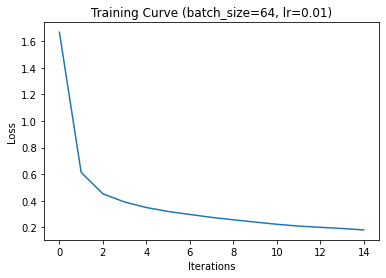

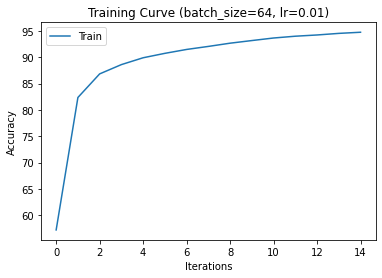

In [13]:
model1 = Net(activation='relu', criterion='nll')
print(model1)

losses1, accuracies1 = train(model1, train_loader, 'nll', 'sgd')
plot(losses1, accuracies1)                            

Test Loss: 0.171226

predictions shape: torch.Size([10000])
test labels shape: torch.Size([10000])
[[7 7]
 [2 2]
 [1 1]
 ...
 [4 4]
 [5 5]
 [6 6]]

Accuracy: 0.9507

confusion matrix:
[[ 962    0    1    0    0    5    6    2    3    1]
 [   0 1112    4    2    0    1    5    3    8    0]
 [  10    1  976    9    6    1    5   11   12    1]
 [   1    1   13  947    0   15    1   11   14    7]
 [   1    1    2    1  930    0   10    2    5   30]
 [   7    1    0   15    4  839   10    0   10    6]
 [   7    3    2    0    8   11  922    2    3    0]
 [   3   11   18    5    2    0    0  973    1   15]
 [   4    5    3   13    6   13   10    9  907    4]
 [   8    6    1    8   20    8    1   12    6  939]]

f1_score for class 0 is: 0.9702471003530005
f1_score for class 1 is: 0.9771528998242531
f1_score for class 2 is: 0.9512670565302145
f1_score for class 3 is: 0.9422885572139302
f1_score for class 4 is: 0.9499489274770174
f1_score for class 5 is: 0.9400560224089636
f1_score for class 6

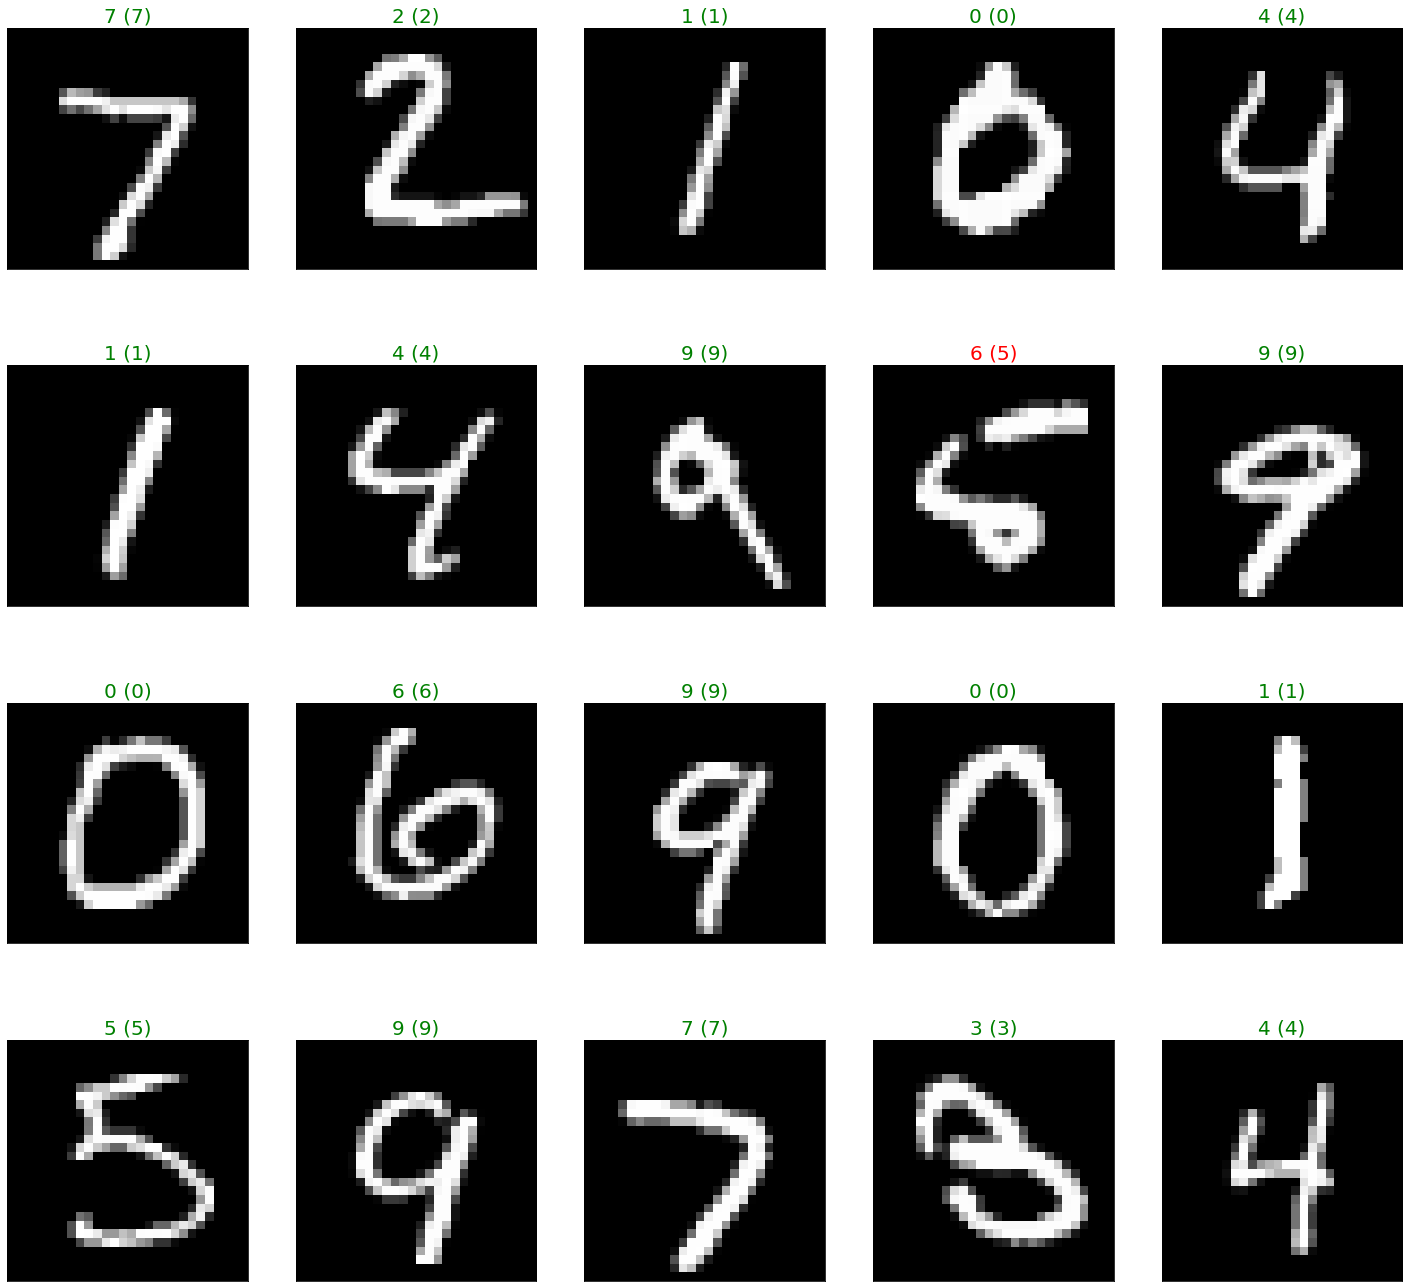

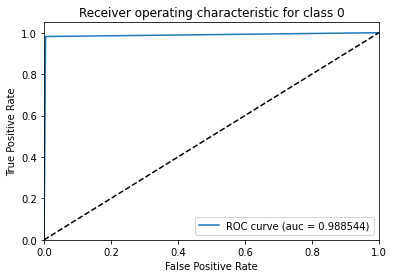

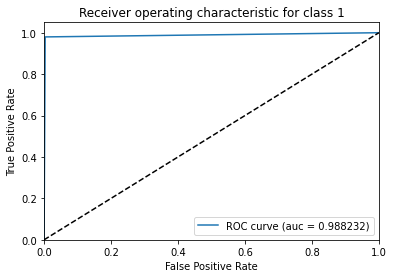

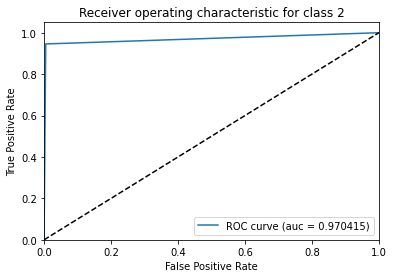

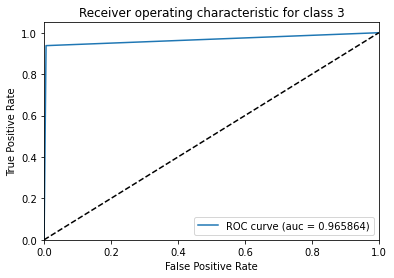

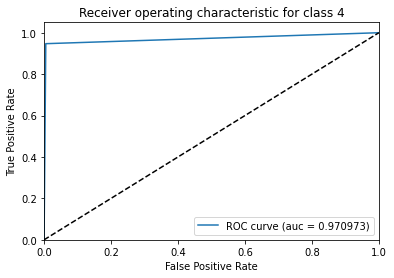

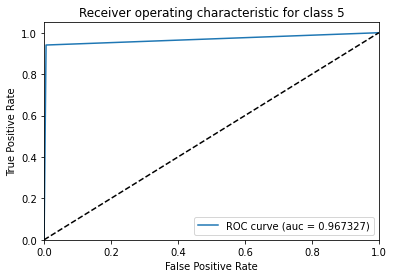

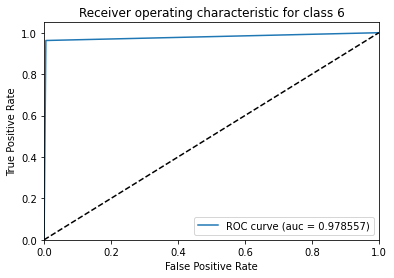

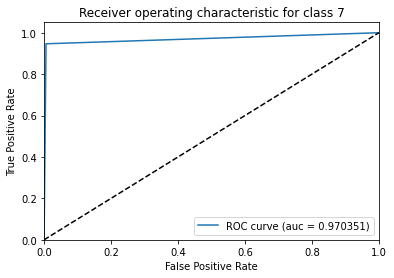

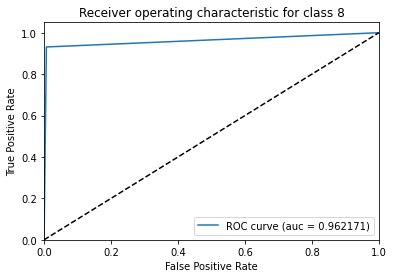

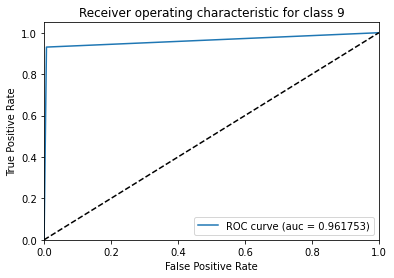

<ipython-input-11-9195afd42829>:49: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


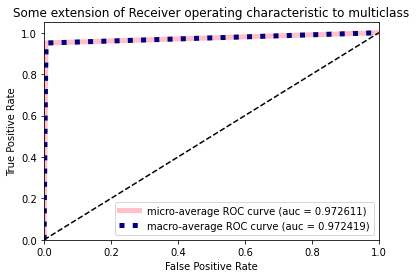

In [14]:
test(model1, test_loader, 'nll')   

## ReLU, NLL, RMSProp

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 0
loss: 2.305297  [   64/60000]
loss: 0.379641  [19264/60000]
loss: 0.665041  [38464/60000]
loss: 0.688591  [57664/60000]
epoch loss: 0.8327
epoch accuracy: 88.2667
*************************
Epoch 1
loss: 0.276361  [   64/60000]
loss: 0.284529  [19264/60000]
loss: 0.179144  [38464/60000]
loss: 0.404002  [57664/60000]
epoch loss: 0.2786
epoch accuracy: 92.7250
*************************
Epoch 2
loss: 0.201504  [   64/60000]
loss: 0.293912  [19264/60000]
loss: 0.170888  [38464/60000]
loss: 0.218173  [57664/60000]
epoch loss: 0.2588
epoch accuracy: 93.5733
*************************
Epoch 3
loss: 0.176866  [   64/60000]
loss: 0.294429  [19264/60000]
loss: 0.714849  [38464/60

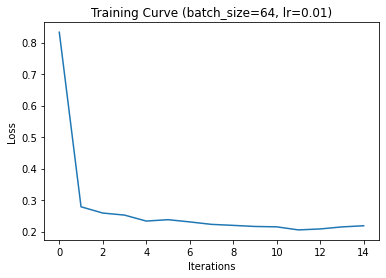

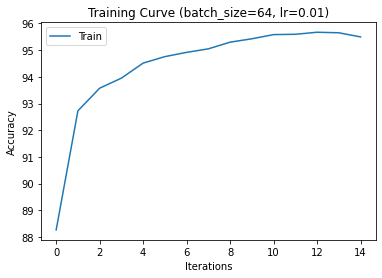

In [15]:
model2 = Net(activation='relu', criterion='nll')
print(model2)

losses2, accuracies2 = train(model2, train_loader, 'nll', 'rms-prop')
plot(losses2, accuracies2)                            

Test Loss: 0.365624

predictions shape: torch.Size([10000])
test labels shape: torch.Size([10000])
[[7 7]
 [2 2]
 [1 1]
 ...
 [4 4]
 [5 5]
 [6 6]]

Accuracy: 0.9493

confusion matrix:
[[ 959    1    0    2    1    1    4    5    5    2]
 [   0 1116    4    1    1    0    0    1   10    2]
 [   2    7  984   10    3    0    2    5   17    2]
 [   1    3   14  964    0    3    0    7   10    8]
 [   1    0    0    0  900    0    8   11    8   54]
 [   2    3    1   47    0  806    6    1   21    5]
 [   7    6    3    1    3   13  911    3    8    3]
 [   0    2   17    5    0    0    0  981   11   12]
 [   4    2    8    7    8    4    6    2  926    7]
 [   5    1    2    8    9    5    0   17   16  946]]

f1_score for class 0 is: 0.9780724120346762
f1_score for class 1 is: 0.9806678383128294
f1_score for class 2 is: 0.9530266343825667
f1_score for class 3 is: 0.9381995133819951
f1_score for class 4 is: 0.9438909281594128
f1_score for class 5 is: 0.9350348027842227
f1_score for class 6

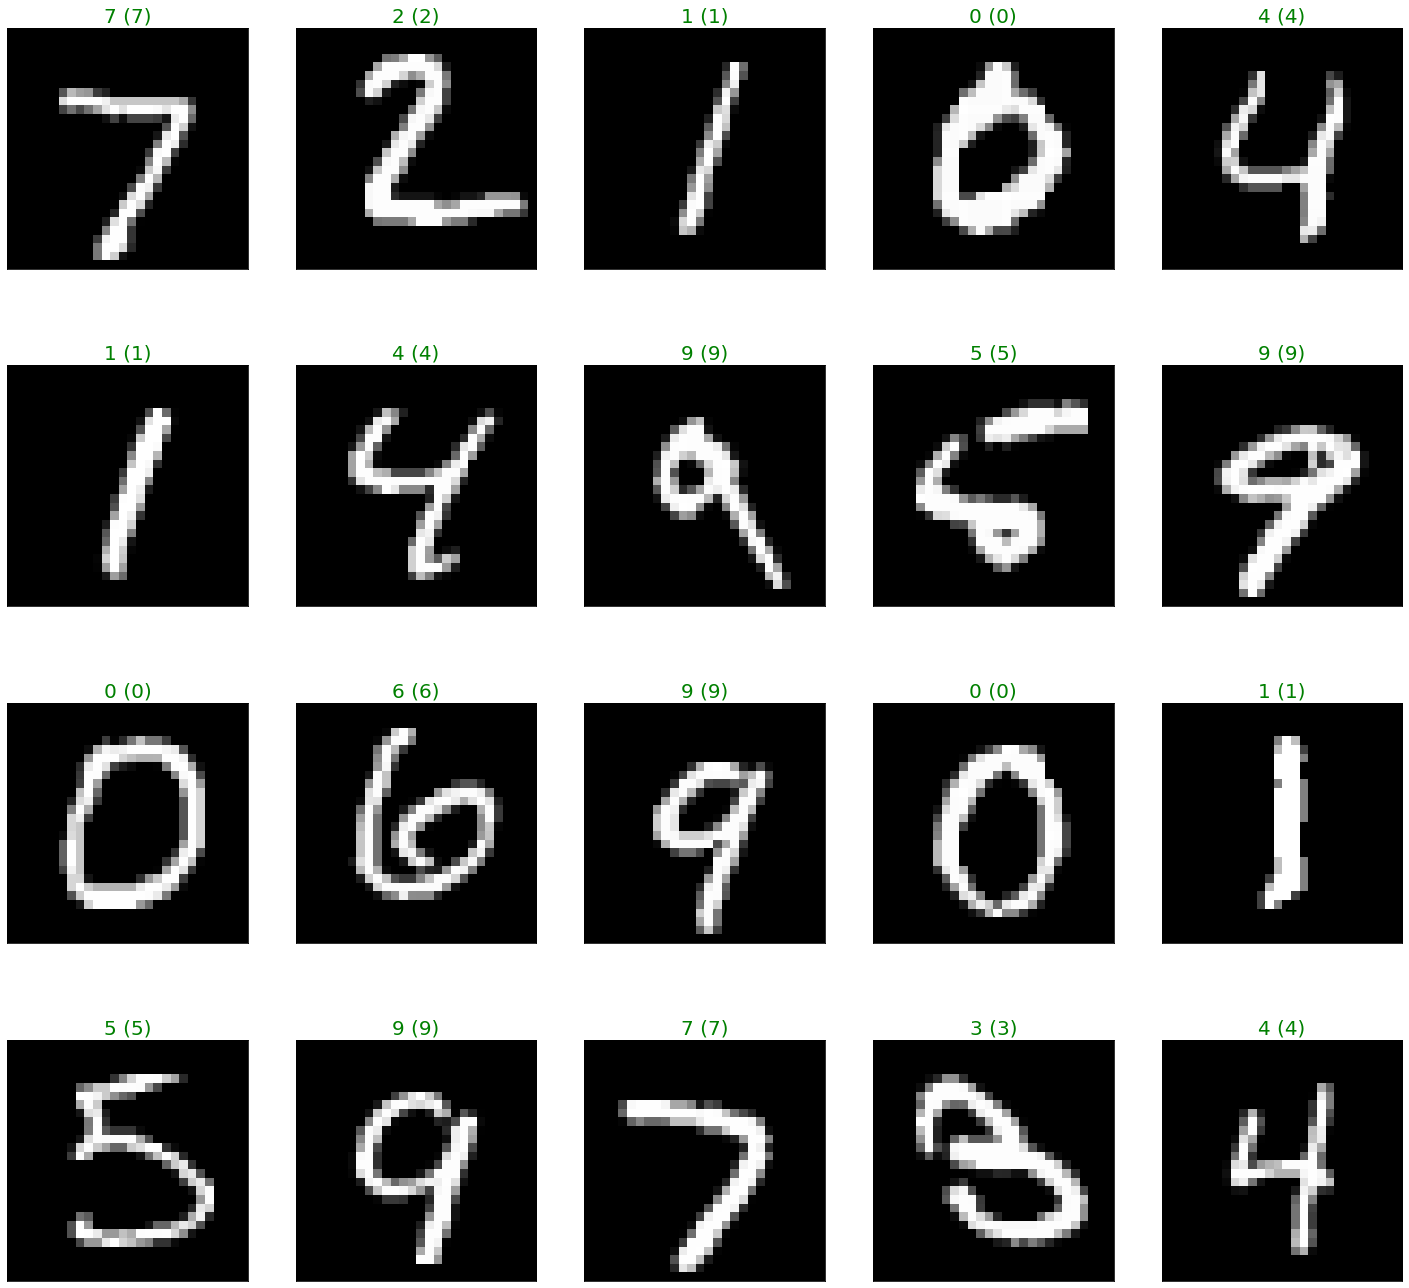

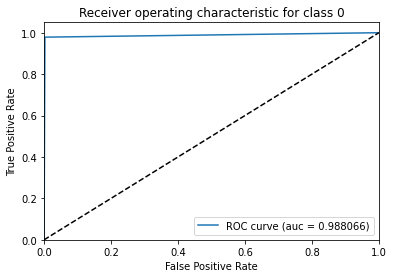

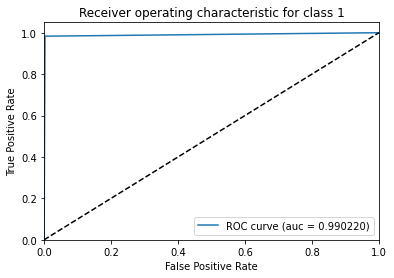

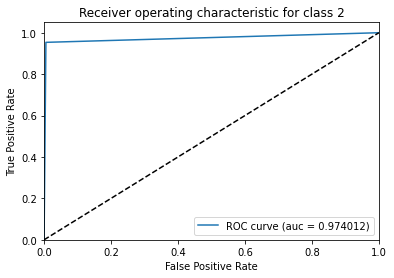

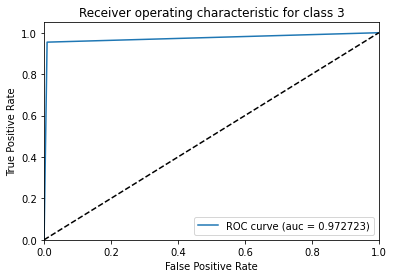

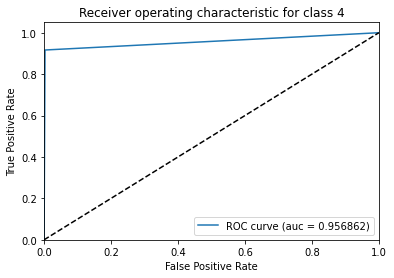

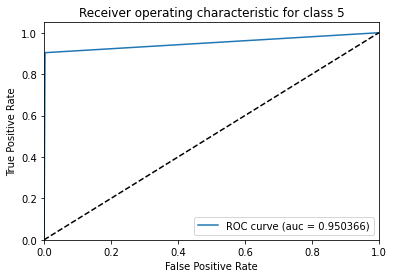

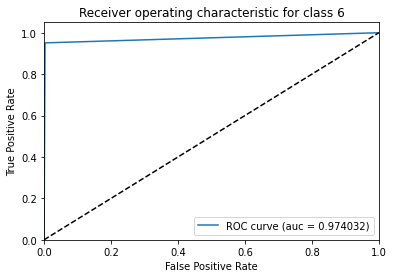

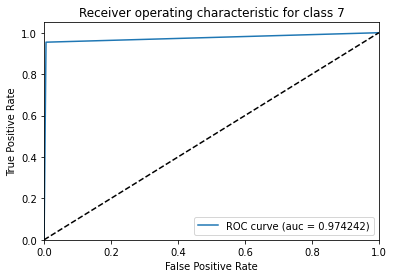

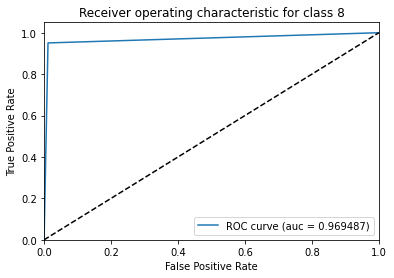

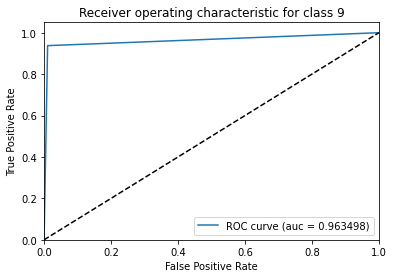

<ipython-input-11-9195afd42829>:49: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


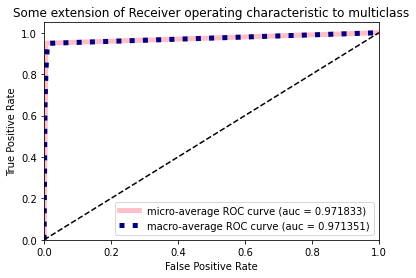

In [16]:
test(model2, test_loader, 'nll')   

## ReLU, CE, Adam

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 0
loss: 2.306163  [   64/60000]
loss: 0.356581  [19264/60000]
loss: 0.169157  [38464/60000]
loss: 0.387485  [57664/60000]
epoch loss: 0.3597
epoch accuracy: 89.9050
*************************
Epoch 1
loss: 0.173160  [   64/60000]
loss: 0.292608  [19264/60000]
loss: 0.186596  [38464/60000]
loss: 0.375541  [57664/60000]
epoch loss: 0.2750
epoch accuracy: 92.7900
*************************
Epoch 2
loss: 0.172748  [   64/60000]
loss: 0.457767  [19264/60000]
loss: 0.118595  [38464/60000]
loss: 0.774832  [57664/60000]
epoch loss: 0.2678
epoch accuracy: 93.2617
*************************
Epoch 3
loss: 0.242020  [   64/60000]
loss: 0.306600  [19264/60000]
loss: 0.057535  [38464/60

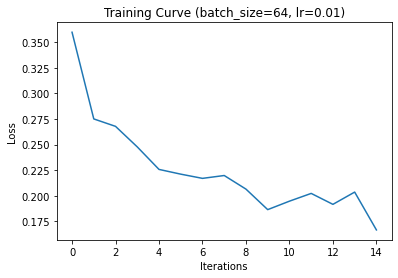

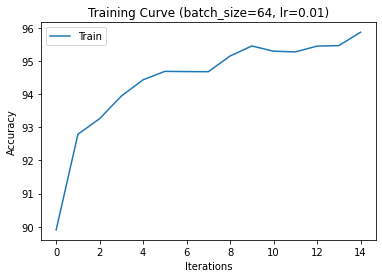

In [17]:
model3 = Net(activation='relu')
print(model3)

losses3, accuracies3 = train(model3, train_loader, 'cross-entropy', 'adam')
plot(losses3, accuracies3)                            

Test Loss: 0.307096

predictions shape: torch.Size([10000])
test labels shape: torch.Size([10000])
[[7 7]
 [2 2]
 [1 1]
 ...
 [4 4]
 [5 5]
 [6 6]]

Accuracy: 0.9505

confusion matrix:
[[ 959    0    0    0    1    1    5    1   10    3]
 [   0 1102    4    6    1    4    1    1   16    0]
 [   6    0  986   13    2    2    1    3   17    2]
 [   1    0    6  963    0   16    0    6   11    7]
 [   1    0    3    0  933    0   10    2    1   32]
 [   4    0    2    9    1  842    5    0   19   10]
 [   9    2    1    0    5   21  911    0    9    0]
 [   4    2   21    8    4    0    0  960   16   13]
 [  16    0    4   13    5    8    7    2  900   19]
 [   2    3    0    9   21   11    0    5    9  949]]

f1_score for class 0 is: 0.9677093844601412
f1_score for class 1 is: 0.982174688057041
f1_score for class 2 is: 0.9577464788732395
f1_score for class 3 is: 0.948301329394387
f1_score for class 4 is: 0.9544757033248081
f1_score for class 5 is: 0.9371174179187534
f1_score for class 6 i

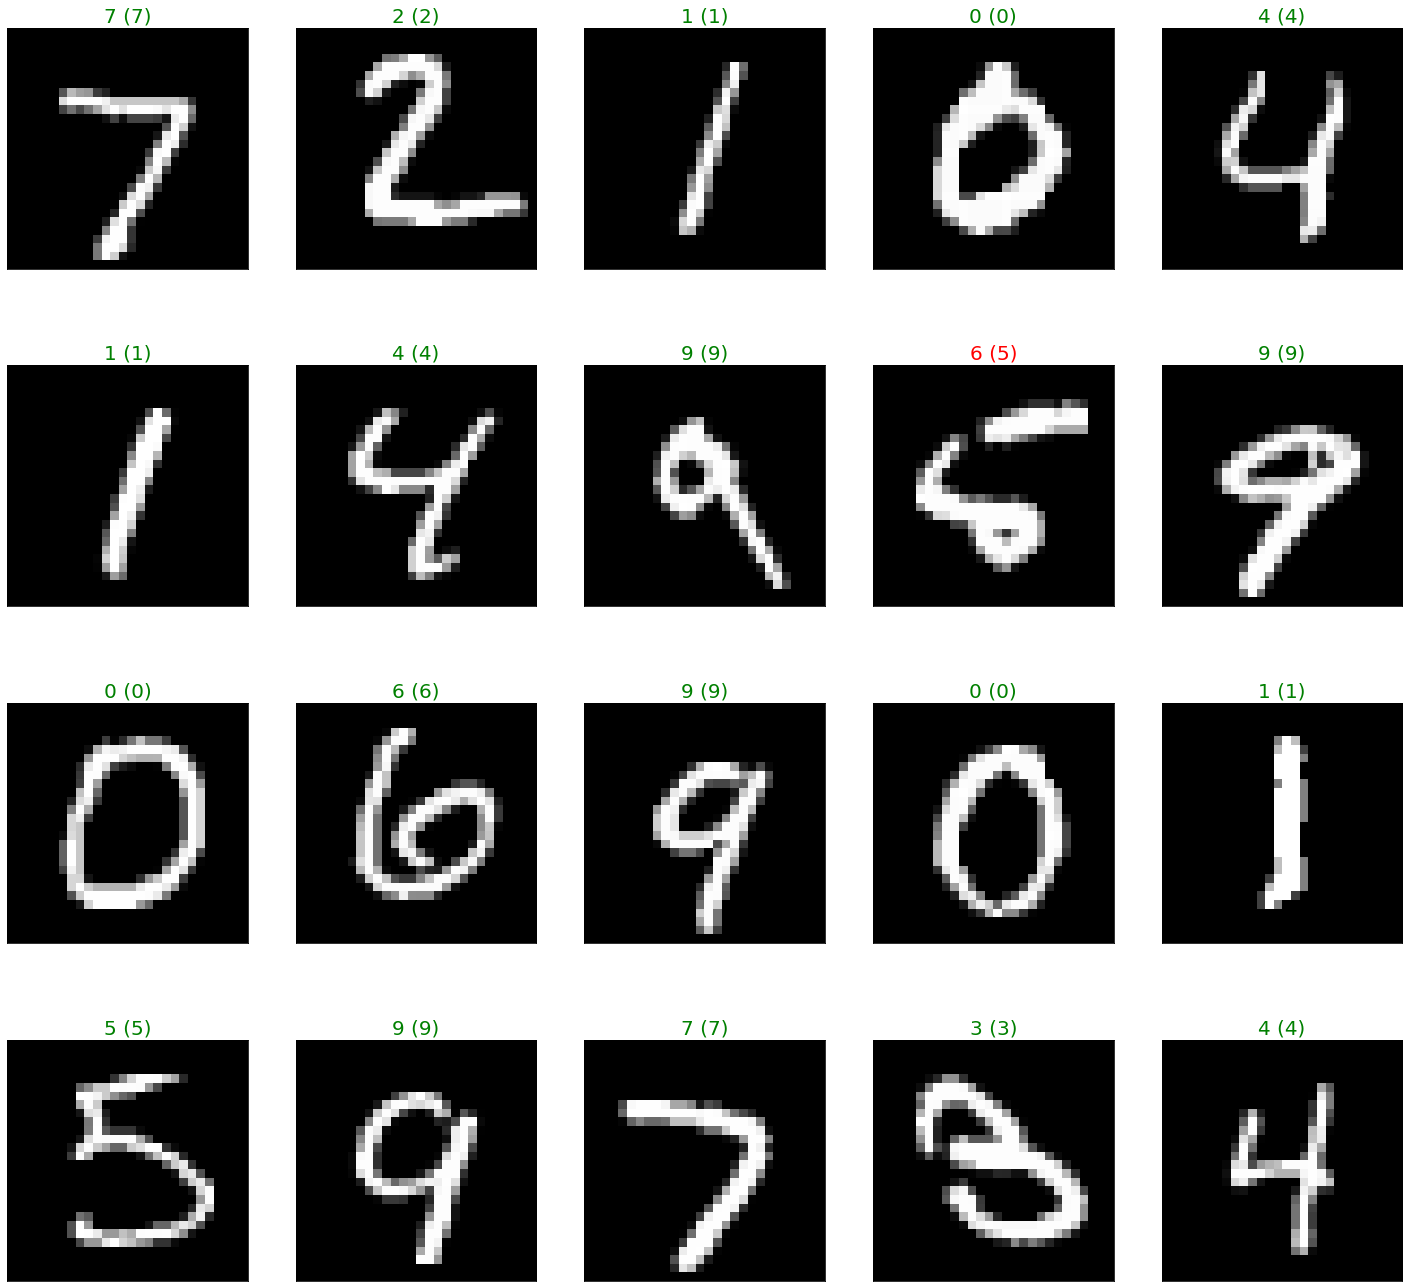

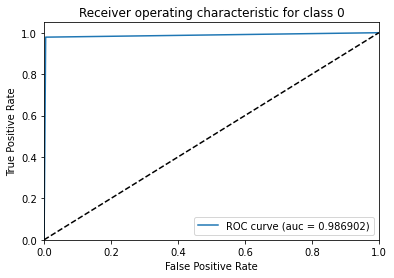

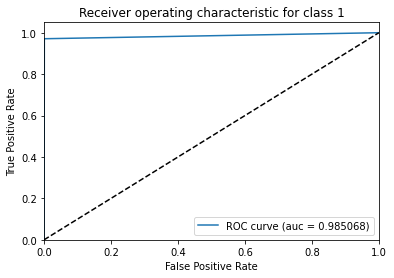

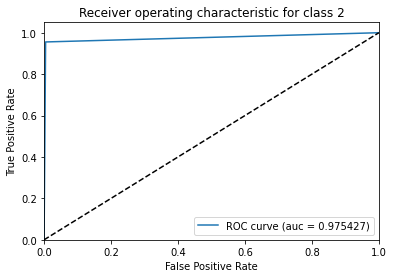

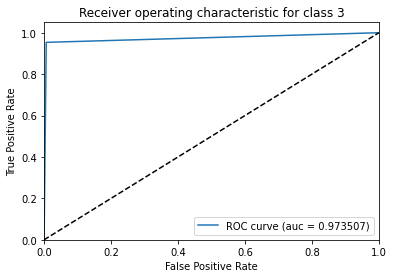

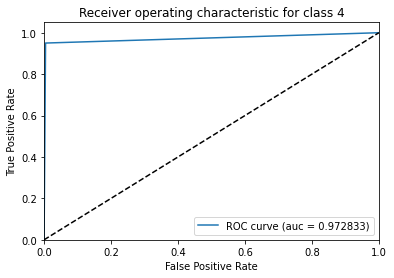

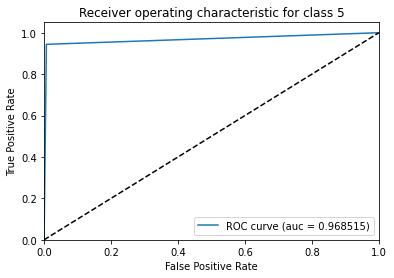

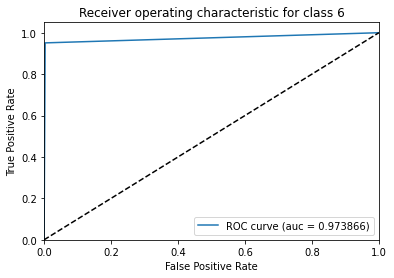

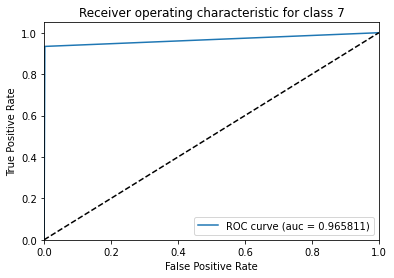

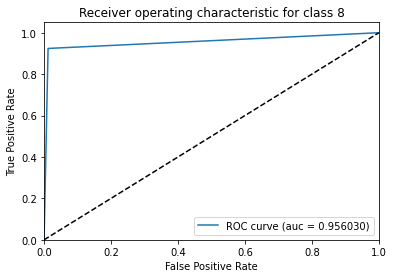

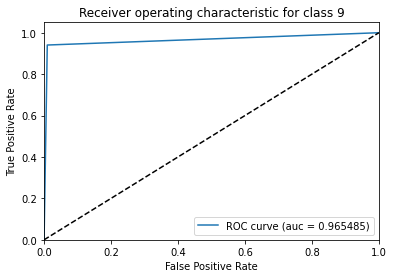

<ipython-input-11-9195afd42829>:49: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


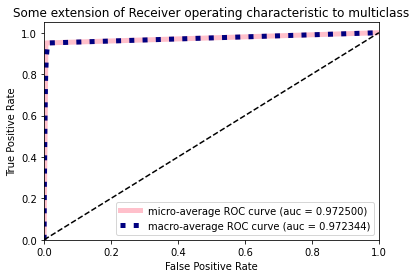

In [18]:
test(model3, test_loader, 'cross-entropy')   

## ReLU, CE, SGD

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 0
loss: 2.317594  [   64/60000]
loss: 2.106391  [19264/60000]
loss: 1.453799  [38464/60000]
loss: 0.914107  [57664/60000]
epoch loss: 1.7292
epoch accuracy: 53.4667
*************************
Epoch 1
loss: 0.899364  [   64/60000]
loss: 0.650195  [19264/60000]
loss: 0.523777  [38464/60000]
loss: 0.606904  [57664/60000]
epoch loss: 0.6308
epoch accuracy: 81.7533
*************************
Epoch 2
loss: 0.511008  [   64/60000]
loss: 0.428638  [19264/60000]
loss: 0.323038  [38464/60000]
loss: 0.473332  [57664/60000]
epoch loss: 0.4548
epoch accuracy: 86.7583
*************************
Epoch 3
loss: 0.400266  [   64/60000]
loss: 0.428228  [19264/60000]
loss: 0.240748  [38464/60

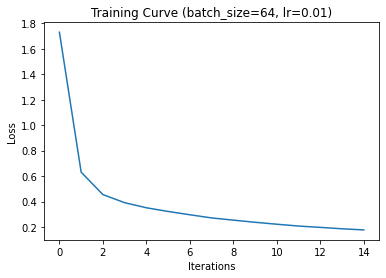

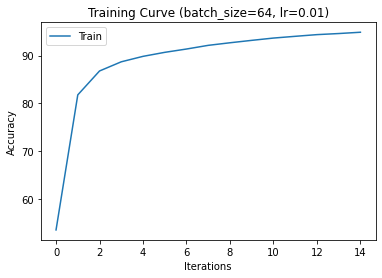

In [19]:
model4 = Net(activation='relu')
print(model4)

losses4, accuracies4 = train(model4, train_loader, 'cross-entropy', 'sgd')
plot(losses4, accuracies4)

Test Loss: 0.171901

predictions shape: torch.Size([10000])
test labels shape: torch.Size([10000])
[[7 7]
 [2 2]
 [1 1]
 ...
 [4 4]
 [5 5]
 [6 6]]

Accuracy: 0.9496

confusion matrix:
[[ 965    0    0    0    0    5    4    2    4    0]
 [   0 1117    3    2    0    1    3    2    7    0]
 [   9    2  972   15    6    0    7   10   10    1]
 [   1    0   11  953    0   17    0   13   11    4]
 [   2    0    5    0  932    1   10    1    5   26]
 [  10    1    1   19    3  829   12    2    9    6]
 [   8    3    2    1    6   14  921    1    2    0]
 [   0   10   16    4    3    1    0  967    2   25]
 [   7    4    4   16    5   15   11   10  897    5]
 [   7    6    1    8   24    4    1    9    6  943]]

f1_score for class 0 is: 0.970336852689794
f1_score for class 1 is: 0.9806848112379281
f1_score for class 2 is: 0.9496824621397167
f1_score for class 3 is: 0.9398422090729782
f1_score for class 4 is: 0.9505354411014788
f1_score for class 5 is: 0.9319842608206858
f1_score for class 6 

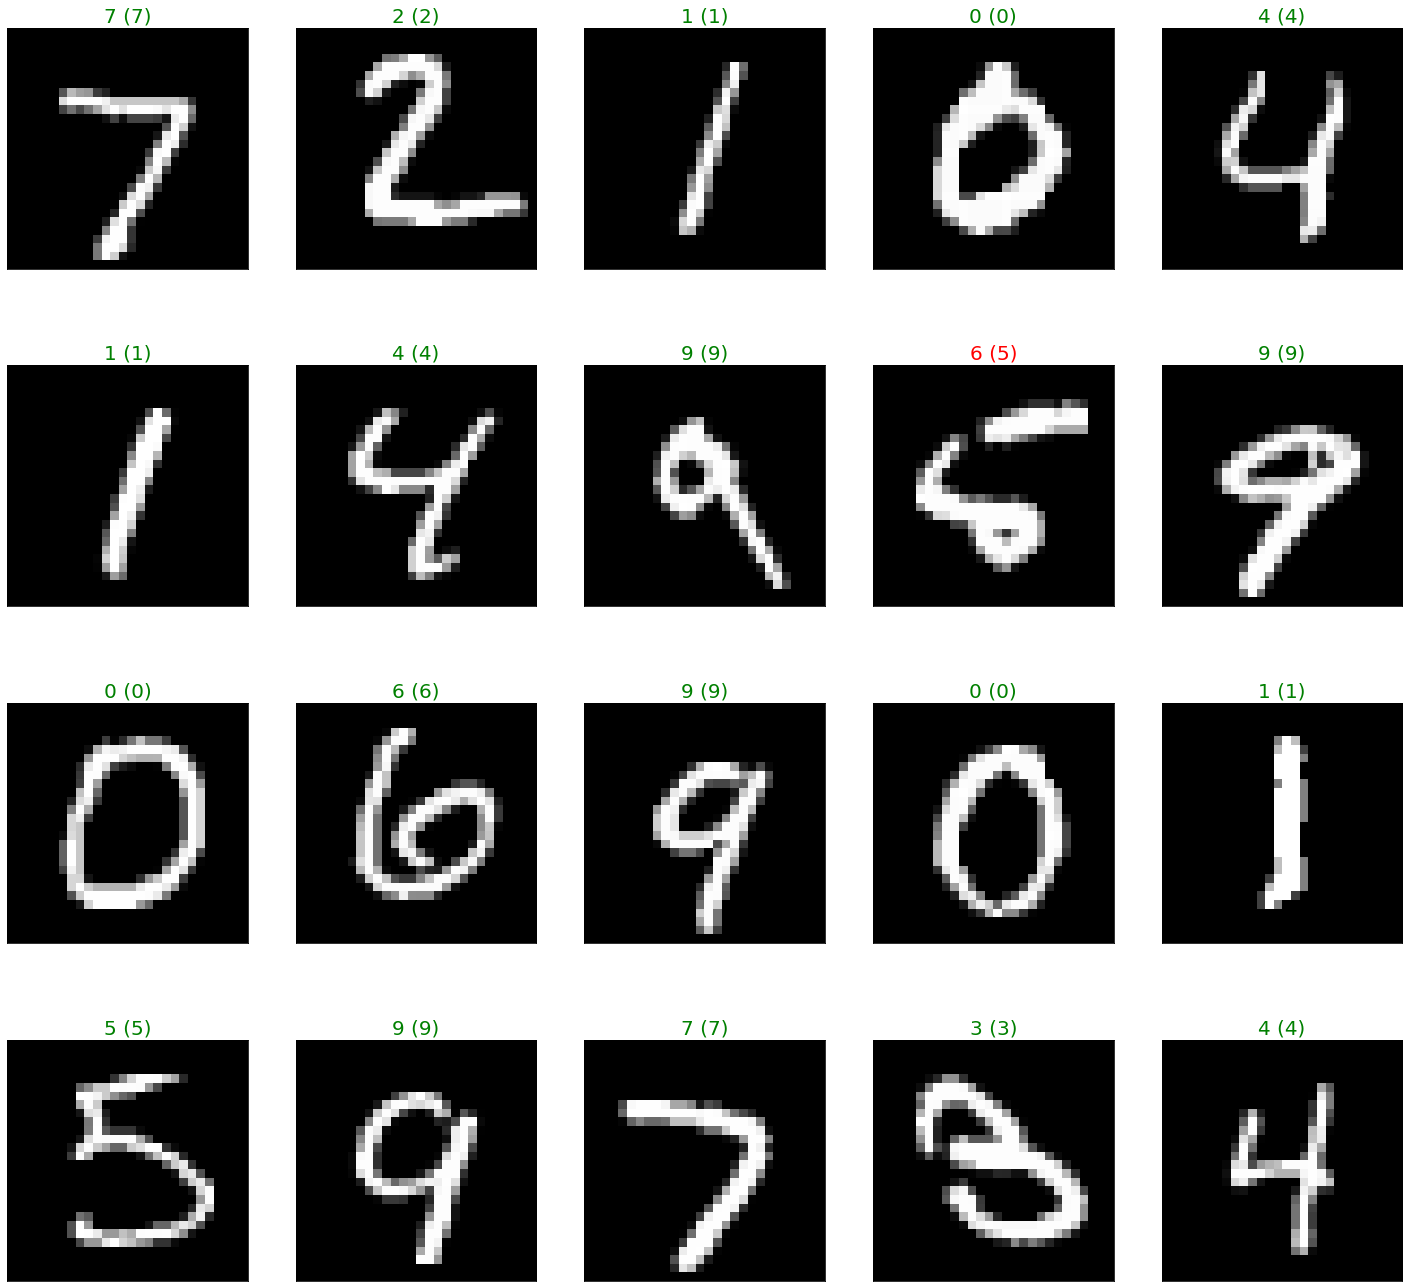

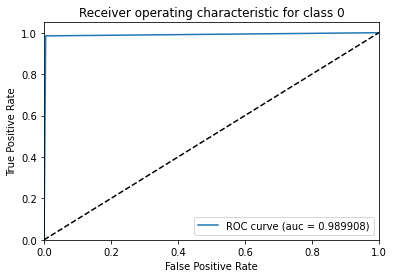

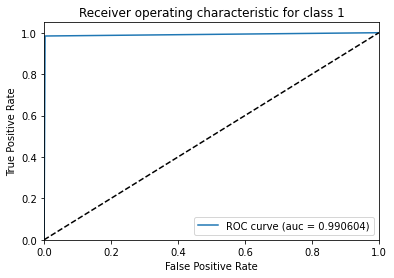

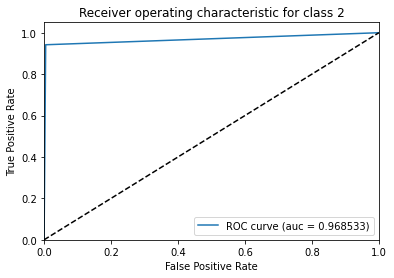

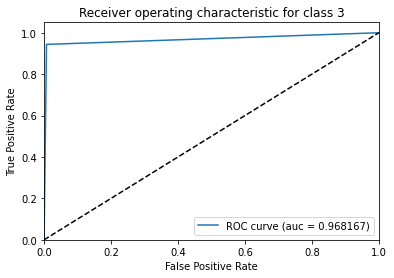

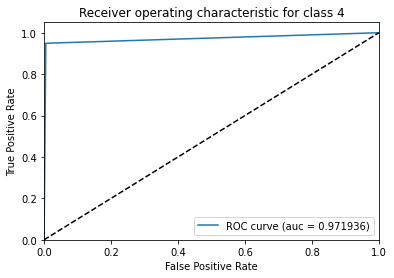

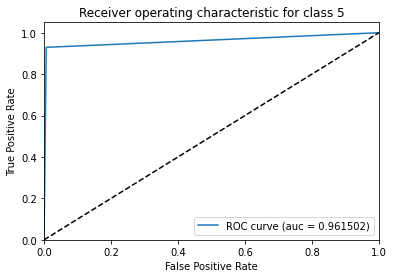

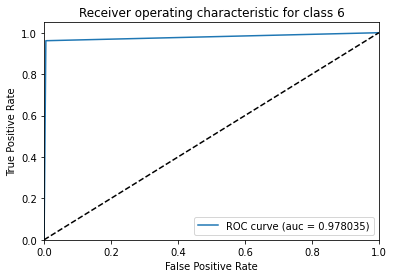

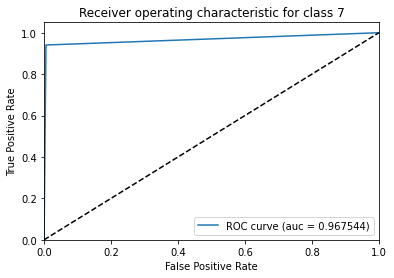

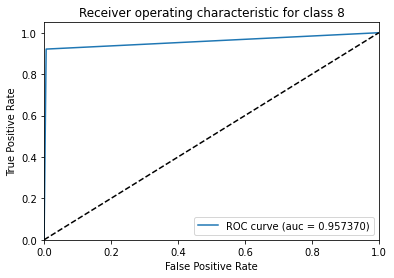

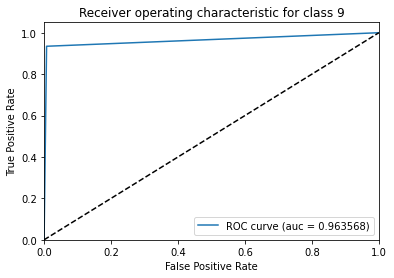

<ipython-input-11-9195afd42829>:49: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


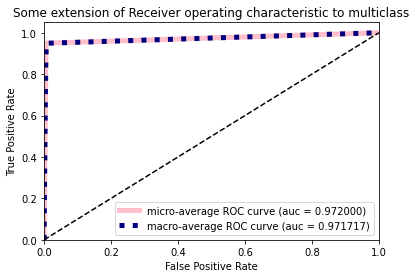

In [20]:
test(model4, test_loader, 'cross-entropy')   

## Tanh, CE, Adam

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (activation): Tanh()
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 0
loss: 2.312658  [   64/60000]
loss: 0.389658  [19264/60000]
loss: 0.454114  [38464/60000]
loss: 0.535580  [57664/60000]
epoch loss: 0.4325
epoch accuracy: 86.8883
*************************
Epoch 1
loss: 0.329398  [   64/60000]
loss: 0.484861  [19264/60000]
loss: 0.327931  [38464/60000]
loss: 0.411550  [57664/60000]
epoch loss: 0.3948
epoch accuracy: 88.3717
*************************
Epoch 2
loss: 0.162403  [   64/60000]
loss: 0.463572  [19264/60000]
loss: 0.260628  [38464/60000]
loss: 0.349655  [57664/60000]
epoch loss: 0.3905
epoch accuracy: 88.5267
*************************
Epoch 3
loss: 0.409734  [   64/60000]
loss: 0.439111  [19264/60000]
loss: 0.472939  [38464/60

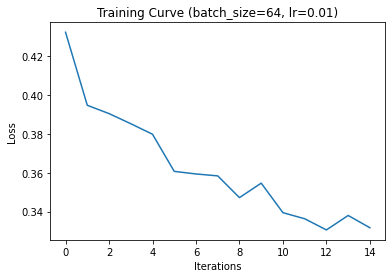

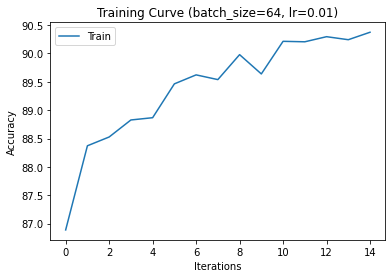

In [21]:
model5 = Net(activation='tanh')
print(model5)

losses5, accuracies5 = train(model5, train_loader, 'cross-entropy', 'adam')
plot(losses5, accuracies5)

Test Loss: 0.305115

predictions shape: torch.Size([10000])
test labels shape: torch.Size([10000])
[[7 7]
 [2 2]
 [1 1]
 ...
 [4 4]
 [5 5]
 [6 6]]

Accuracy: 0.9116

confusion matrix:
[[ 912    0    5    1    3   20   15   10    6    8]
 [   0 1119    4    3    0    2    2    3    2    0]
 [  13    7  937   20   11    2    5   16   19    2]
 [   2    7   15  911    0   38    0   10   16   11]
 [   1    2    6    0  893    1    8    2    4   65]
 [   9    2    2   36   11  775    7    4   28   18]
 [  18    5    6    0   18   19  880    0   11    1]
 [   1   15   20    7    8    1    0  955    0   21]
 [   7   17    9   21    6   37    8   11  823   35]
 [   3    6    1   12   22   10    1   37    6  911]]

f1_score for class 0 is: 0.9373072970195272
f1_score for class 1 is: 0.9667386609071275
f1_score for class 2 is: 0.9199803632793323
f1_score for class 3 is: 0.9015338941118258
f1_score for class 4 is: 0.9140225179119754
f1_score for class 5 is: 0.8625486922648858
f1_score for class 6

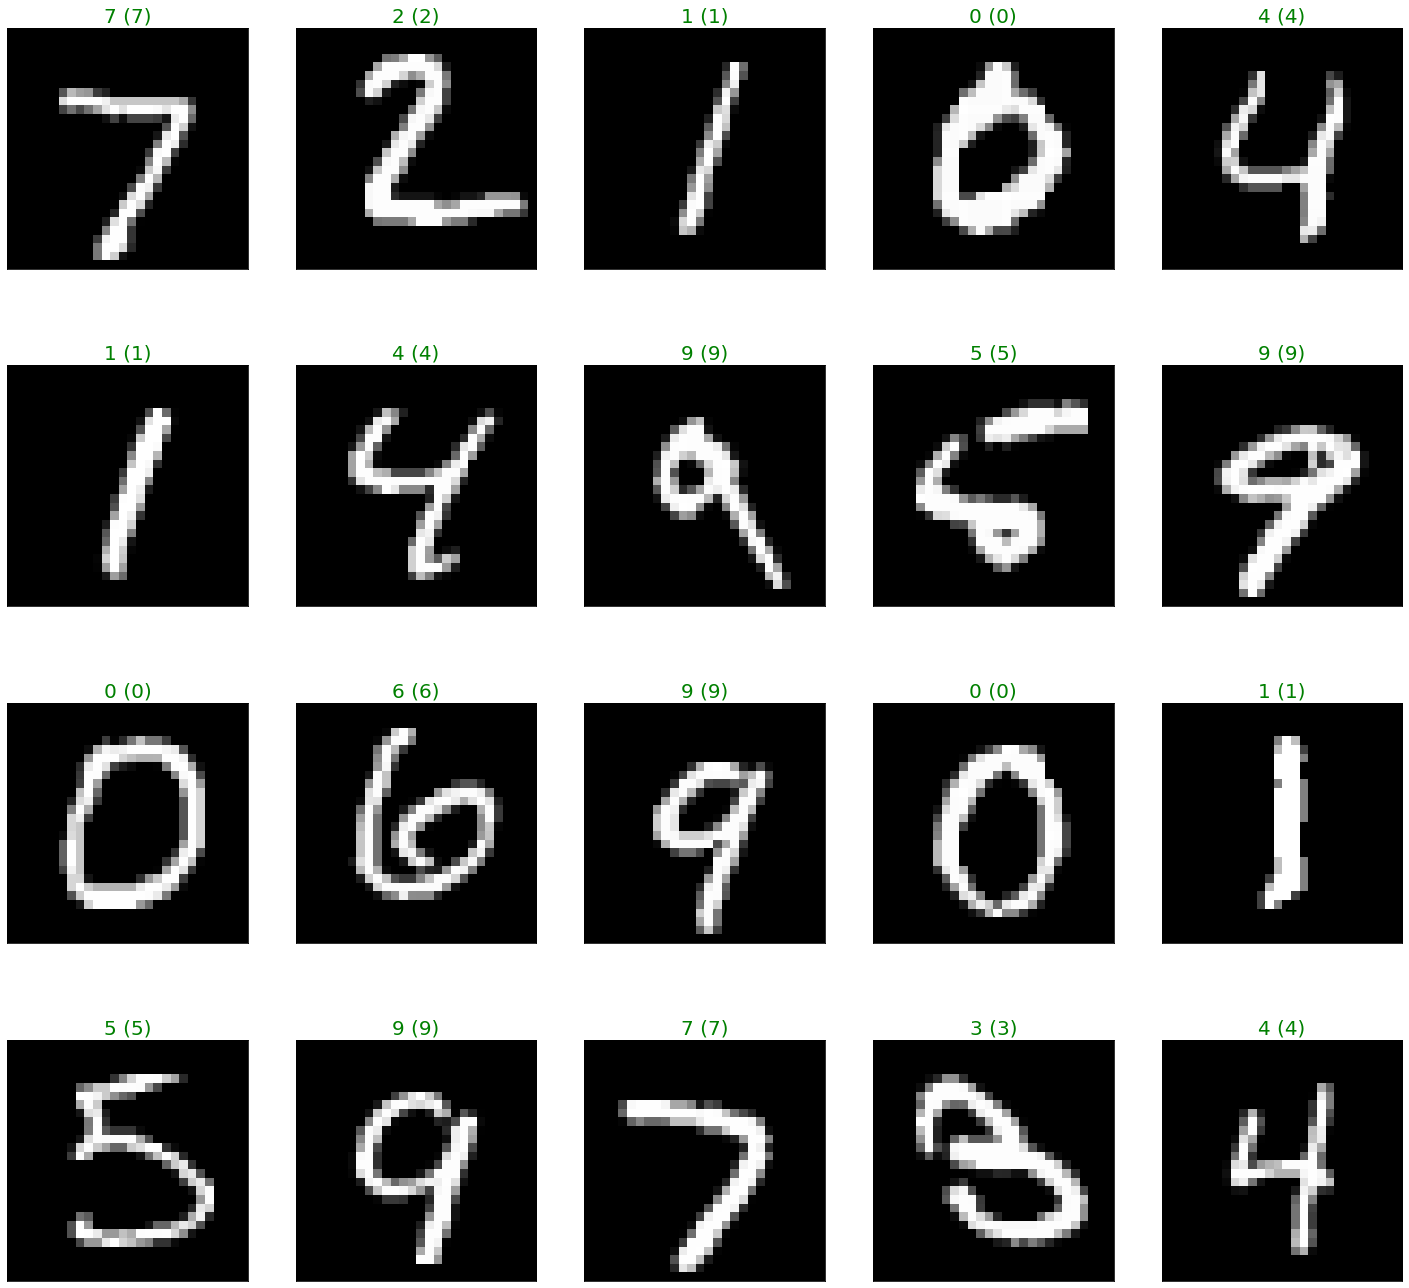

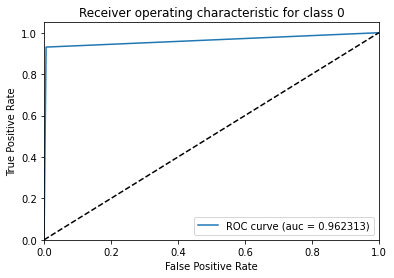

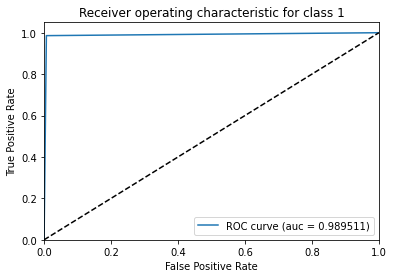

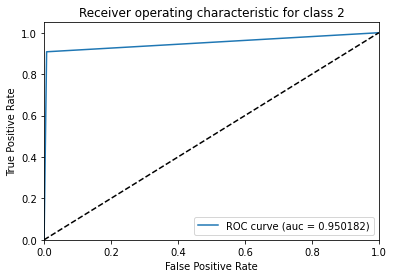

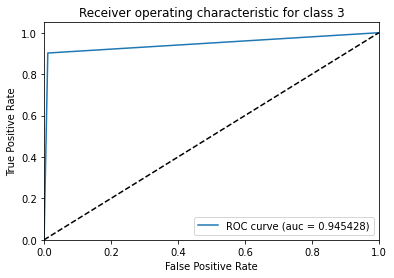

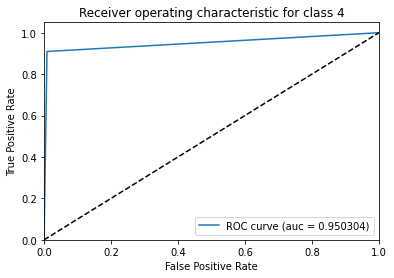

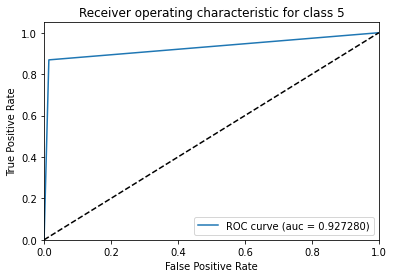

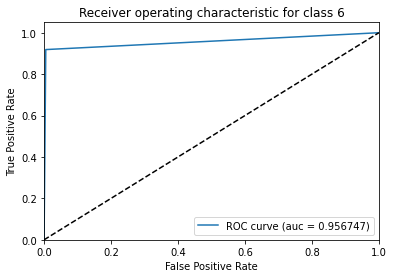

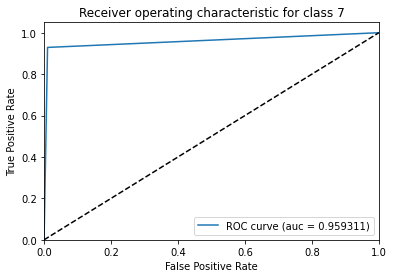

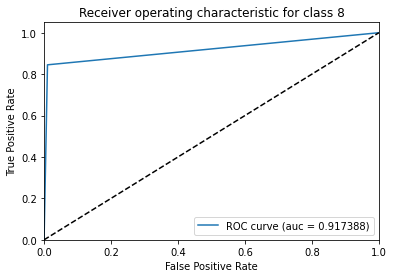

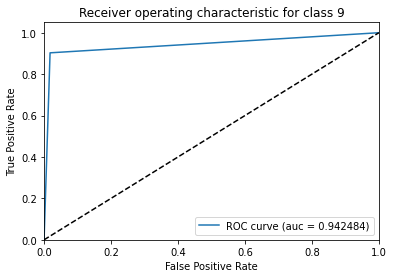

<ipython-input-11-9195afd42829>:49: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


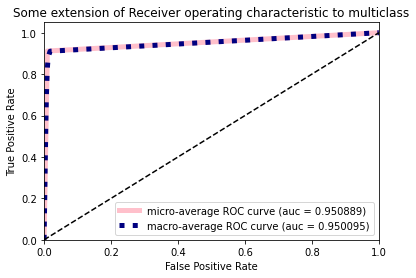

In [22]:
test(model5, test_loader, 'cross-entropy')   

## Tanh, NLL, SGD

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (activation): Tanh()
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 0
loss: 2.333684  [   64/60000]
loss: 1.490655  [19264/60000]
loss: 0.777475  [38464/60000]
loss: 0.669148  [57664/60000]
epoch loss: 1.2663
epoch accuracy: 71.9317
*************************
Epoch 1
loss: 0.669942  [   64/60000]
loss: 0.514218  [19264/60000]
loss: 0.373910  [38464/60000]
loss: 0.492554  [57664/60000]
epoch loss: 0.5058
epoch accuracy: 86.6800
*************************
Epoch 2
loss: 0.415667  [   64/60000]
loss: 0.418244  [19264/60000]
loss: 0.294071  [38464/60000]
loss: 0.498544  [57664/60000]
epoch loss: 0.4012
epoch accuracy: 88.8300
*************************
Epoch 3
loss: 0.358981  [   64/60000]
loss: 0.367411  [19264/60000]
loss: 0.263133  [38464/60

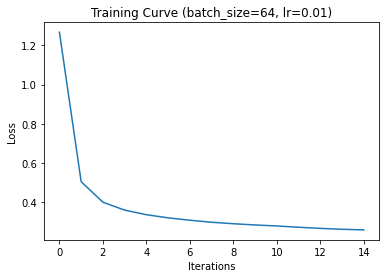

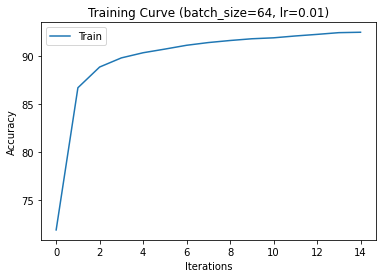

In [23]:
model6 = Net(activation='tanh', criterion='nll')
print(model6)

losses6, accuracies6 = train(model6, train_loader, 'nll', 'sgd')
plot(losses6, accuracies6)

Test Loss: 0.254482

predictions shape: torch.Size([10000])
test labels shape: torch.Size([10000])
[[7 7]
 [2 2]
 [1 1]
 ...
 [4 4]
 [5 5]
 [6 6]]

Accuracy: 0.9279

confusion matrix:
[[ 964    0    1    2    0    3    5    1    4    0]
 [   0 1111    3    3    0    2    3    2   11    0]
 [  10    4  933   13   10    2   14   10   32    4]
 [   4    1   17  920    0   29    1   13   19    6]
 [   3    1    4    1  911    0   10    2   10   40]
 [   8    3    4   34    7  791    8    4   27    6]
 [  13    3    3    0    7   15  912    3    2    0]
 [   3   10   24    7    6    0    0  945    1   32]
 [   7    9    5   22    9   26   11   10  868    7]
 [  11    5    1    9   25    6    0   21    7  924]]

f1_score for class 0 is: 0.962556165751373
f1_score for class 1 is: 0.9737072743207713
f1_score for class 2 is: 0.9205722742969906
f1_score for class 3 is: 0.9104403760514597
f1_score for class 4 is: 0.9310168625447113
f1_score for class 5 is: 0.8958097395243488
f1_score for class 6 

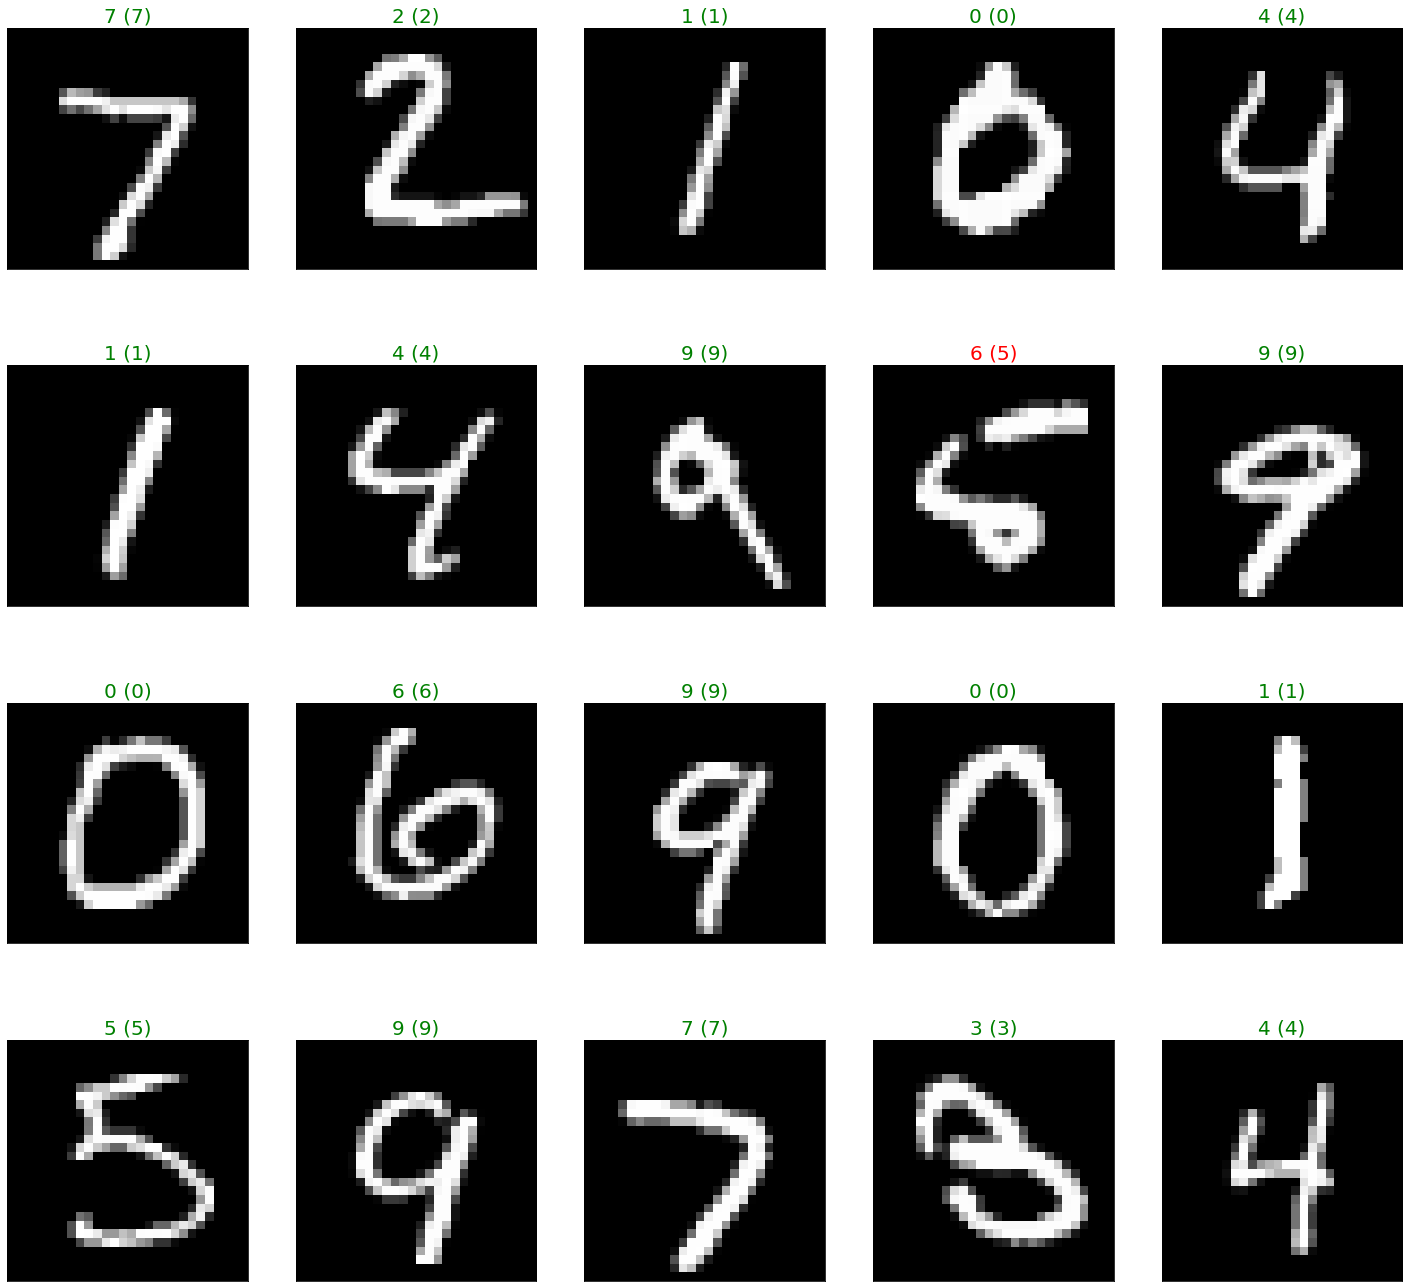

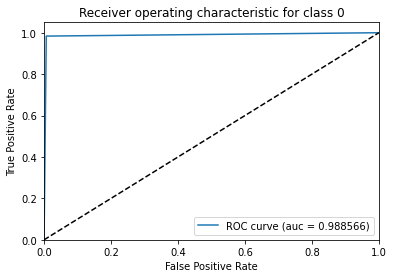

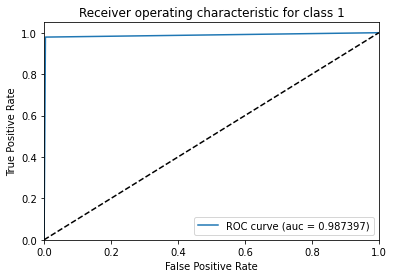

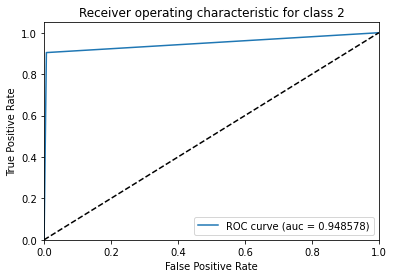

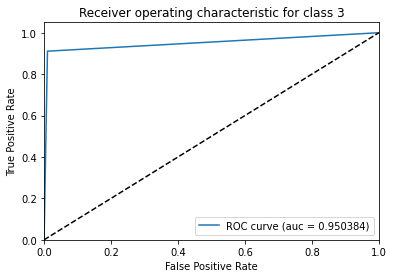

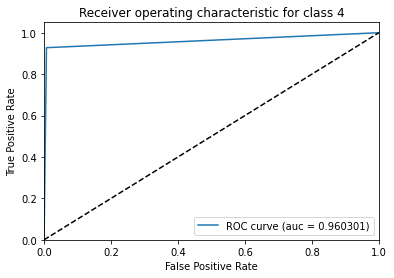

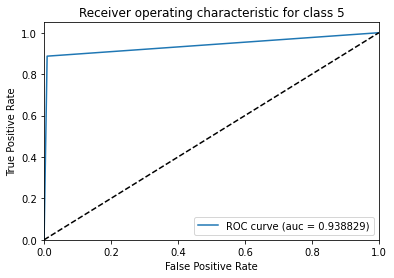

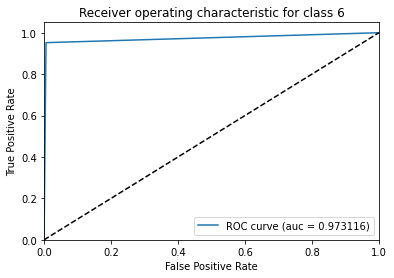

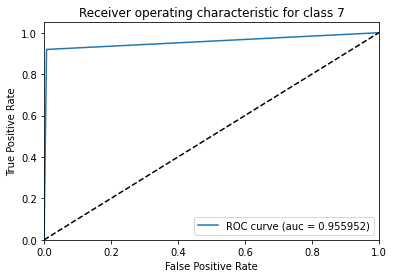

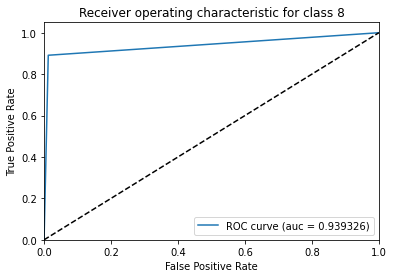

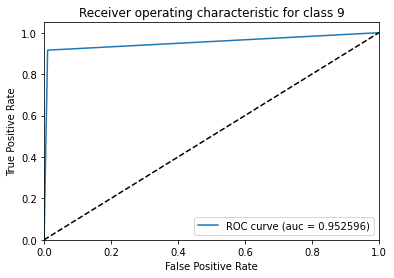

<ipython-input-11-9195afd42829>:49: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


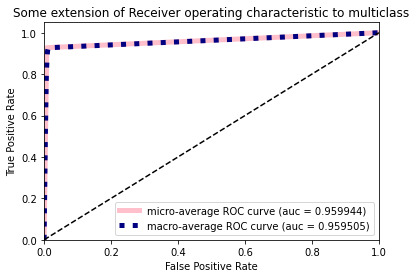

In [24]:
test(model6, test_loader, 'nll')   

## Tanh, NLL, RMSProp

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (activation): Tanh()
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 0
loss: 2.321697  [   64/60000]
loss: 0.409319  [19264/60000]
loss: 0.431667  [38464/60000]
loss: 0.674040  [57664/60000]
epoch loss: 0.6184
epoch accuracy: 82.3217
*************************
Epoch 1
loss: 0.273163  [   64/60000]
loss: 0.533080  [19264/60000]
loss: 0.391259  [38464/60000]
loss: 0.524102  [57664/60000]
epoch loss: 0.3748
epoch accuracy: 89.0283
*************************
Epoch 2
loss: 0.239274  [   64/60000]
loss: 0.639113  [19264/60000]
loss: 0.505955  [38464/60000]
loss: 0.406812  [57664/60000]
epoch loss: 0.3381
epoch accuracy: 90.2800
*************************
Epoch 3
loss: 0.188687  [   64/60000]
loss: 0.285182  [19264/60000]
loss: 0.370748  [38464/60

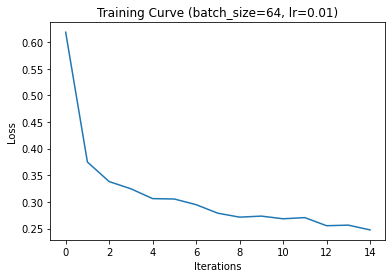

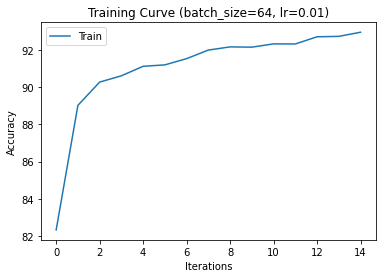

In [25]:
model7 = Net(activation='tanh', criterion='nll')
print(model7)

losses7, accuracies7 = train(model7, train_loader, 'nll', 'rms-prop')
plot(losses7, accuracies7)

Test Loss: 0.313152

predictions shape: torch.Size([10000])
test labels shape: torch.Size([10000])
[[7 7]
 [2 2]
 [1 1]
 ...
 [9 4]
 [5 5]
 [6 6]]

Accuracy: 0.9118

confusion matrix:
[[ 924    0    8    1    0   11   15    1    9   11]
 [   0 1118    3    1    0    0    4    0    9    0]
 [   6   13  956   16    2    2    9    4   19    5]
 [   0    7   21  905    0   31    3    4   11   28]
 [   1    0    7    1  830    2   11    1    7  122]
 [   5    1    2   10    1  772   14    1   29   57]
 [   7    3    8    1    5   21  904    0    9    0]
 [   1    7   44    7    7    2    0  871    3   86]
 [   0   13   11   12    4   20    6    1  869   38]
 [   3    5    2    5   15    3    1    2    4  969]]

f1_score for class 0 is: 0.9590036325895174
f1_score for class 1 is: 0.9713292788879235
f1_score for class 2 is: 0.9130850047755492
f1_score for class 3 is: 0.9192483494159471
f1_score for class 4 is: 0.8992416034669556
f1_score for class 5 is: 0.8792710706150341
f1_score for class 6

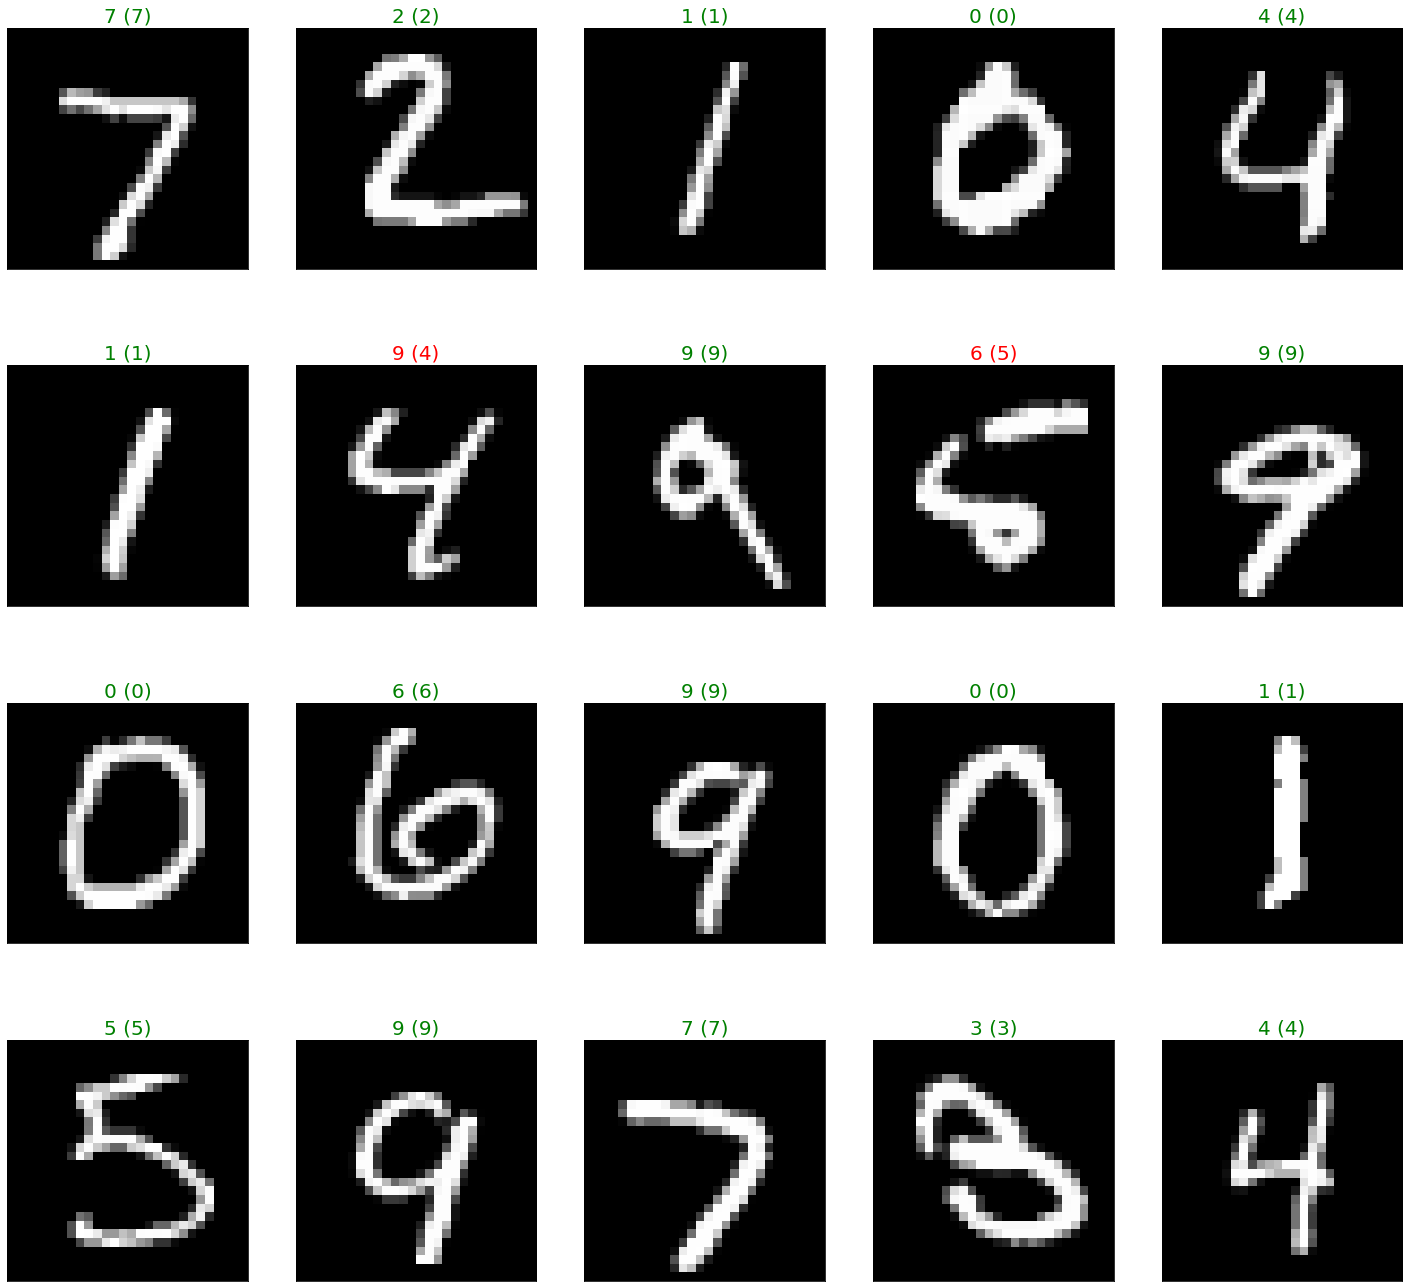

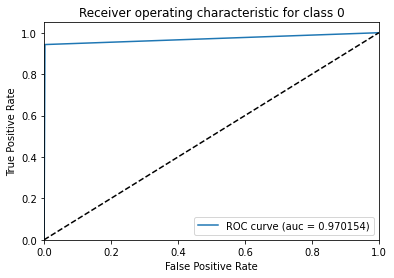

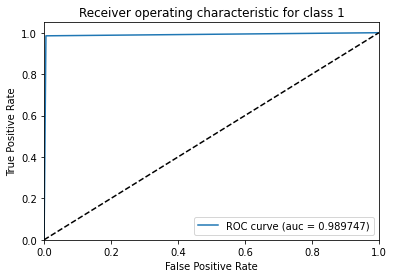

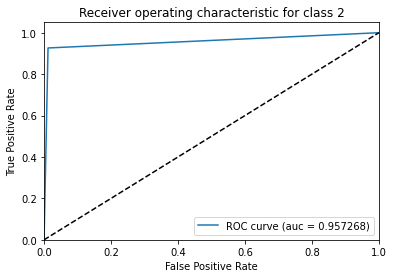

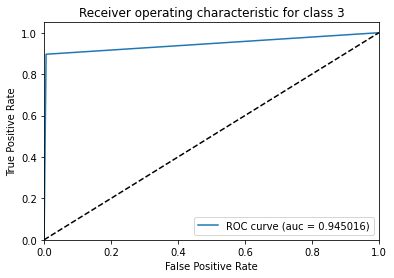

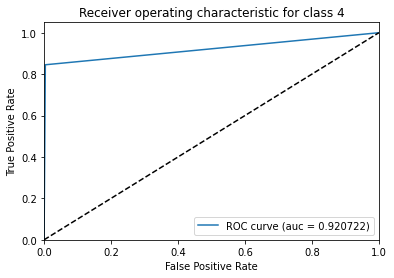

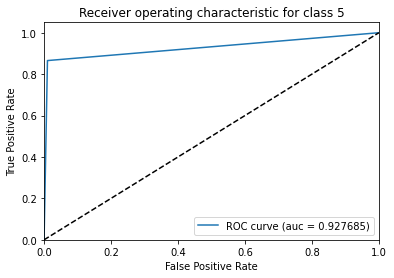

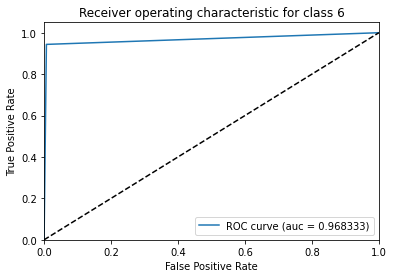

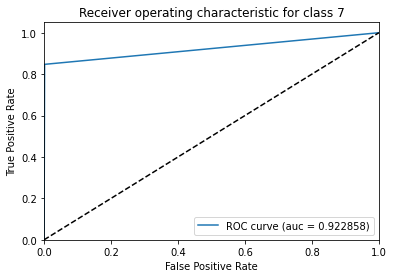

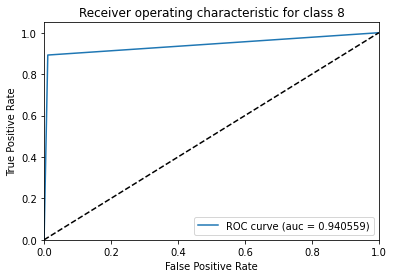

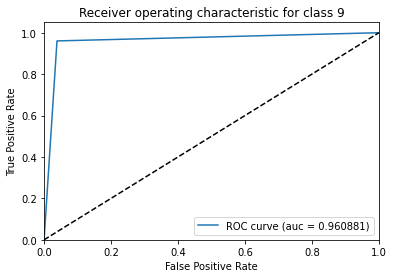

<ipython-input-11-9195afd42829>:49: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


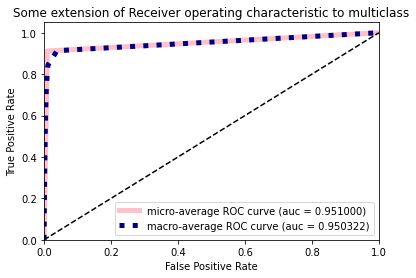

In [26]:
test(model7, test_loader, 'nll')   

## Sigmoid, CE, Adam

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (activation): Sigmoid()
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 0
loss: 2.402112  [   64/60000]
loss: 0.312245  [19264/60000]
loss: 0.247728  [38464/60000]
loss: 0.198158  [57664/60000]
epoch loss: 0.2890
epoch accuracy: 91.2967
*************************
Epoch 1
loss: 0.096942  [   64/60000]
loss: 0.168481  [19264/60000]
loss: 0.090975  [38464/60000]
loss: 0.183164  [57664/60000]
epoch loss: 0.1457
epoch accuracy: 95.6233
*************************
Epoch 2
loss: 0.066657  [   64/60000]
loss: 0.150860  [19264/60000]
loss: 0.054804  [38464/60000]
loss: 0.100581  [57664/60000]
epoch loss: 0.1214
epoch accuracy: 96.4033
*************************
Epoch 3
loss: 0.111189  [   64/60000]
loss: 0.174017  [19264/60000]
loss: 0.136134  [38464

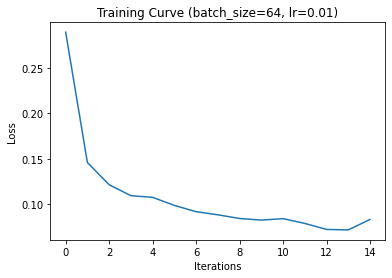

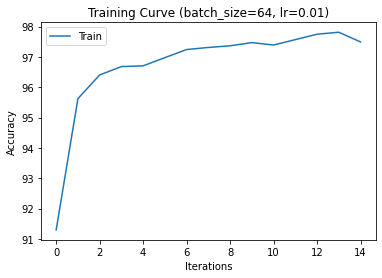

In [27]:
model8 = Net(activation='sigmoid')
print(model8)

losses8, accuracies8 = train(model8, train_loader, 'cross-entropy', 'adam')
plot(losses8, accuracies8)

Test Loss: 0.129283

predictions shape: torch.Size([10000])
test labels shape: torch.Size([10000])
[[7 7]
 [2 2]
 [1 1]
 ...
 [4 4]
 [5 5]
 [6 6]]

Accuracy: 0.9645

confusion matrix:
[[ 967    0    1    1    1    2    3    1    3    1]
 [   0 1125    3    2    0    1    3    0    1    0]
 [  12    3 1000    3    1    0    2    6    4    1]
 [   0    1   10  947    0   24    0    6    5   17]
 [   4    2    3    0  935    1   11    2    2   22]
 [   2    2    0    4    0  874    2    3    4    1]
 [   7    4    0    0    2   14  926    0    4    1]
 [   0    6   18    2    3    2    0  980    3   14]
 [   8    4    7    5    3   13    3    4  919    8]
 [   5    6    0    6    5    5    1    4    5  972]]

f1_score for class 0 is: 0.9743073047858942
f1_score for class 1 is: 0.9833916083916083
f1_score for class 2 is: 0.9643201542912246
f1_score for class 3 is: 0.9565656565656565
f1_score for class 4 is: 0.9679089026915113
f1_score for class 5 is: 0.9562363238512035
f1_score for class 6

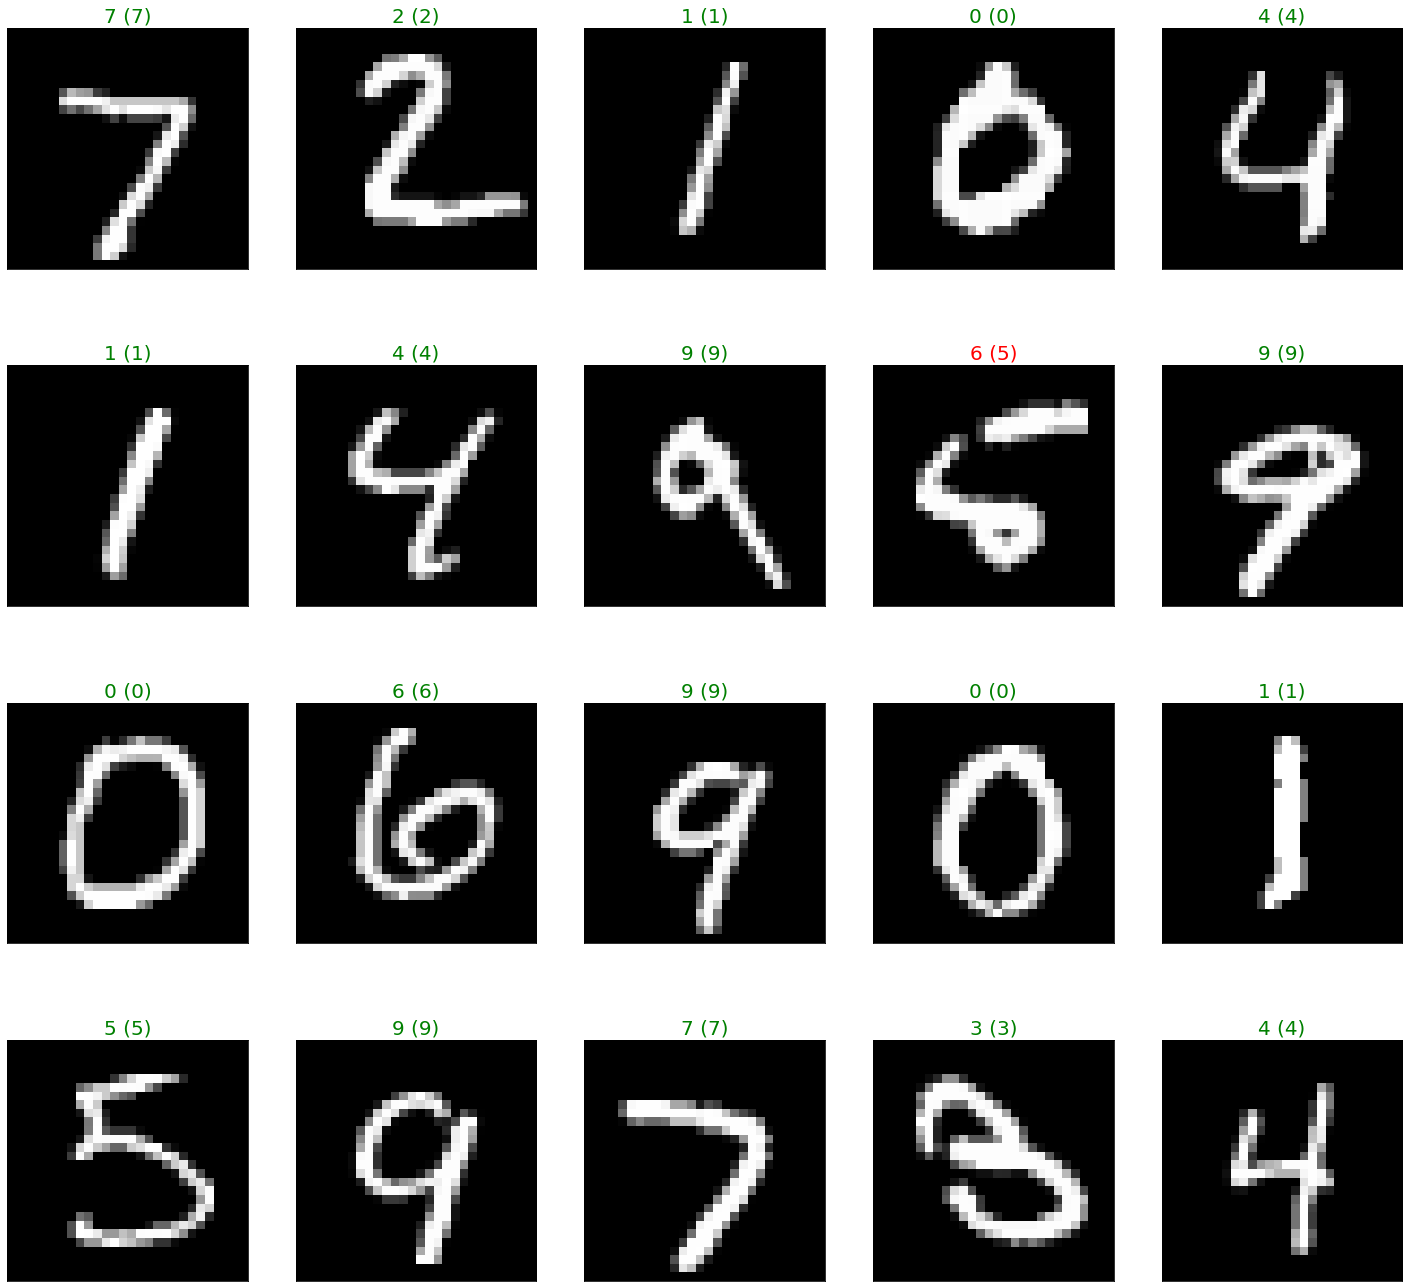

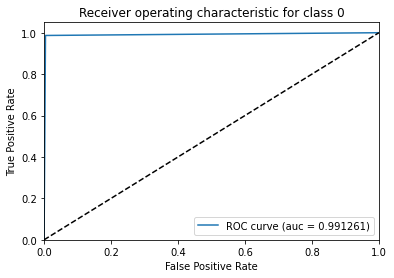

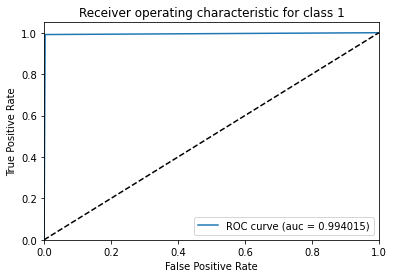

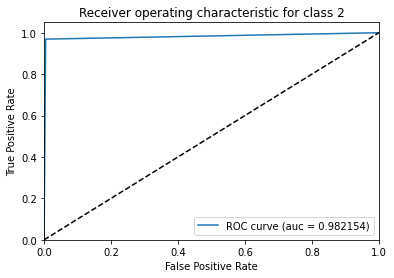

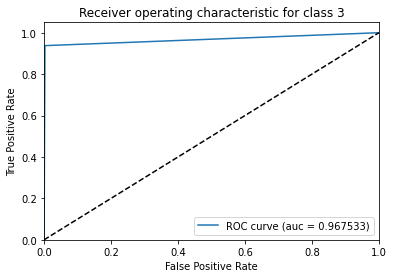

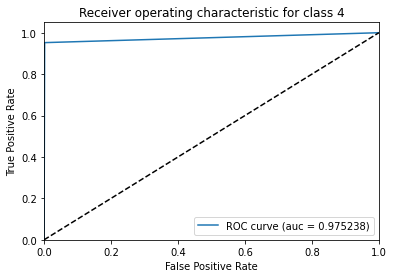

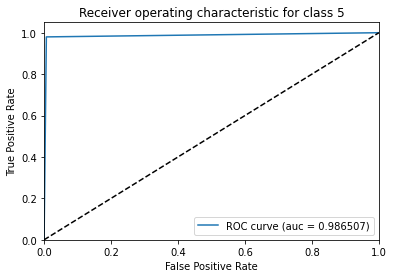

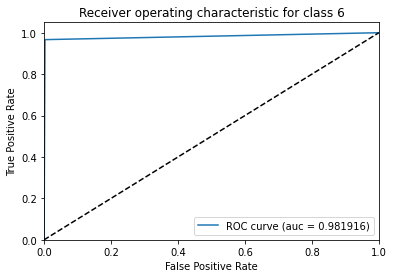

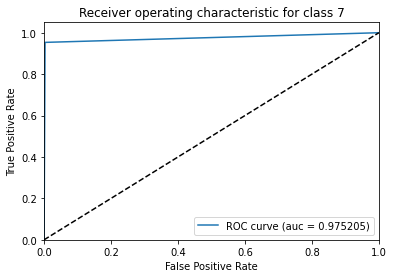

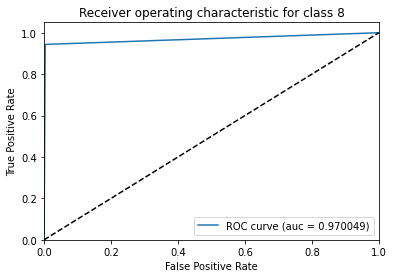

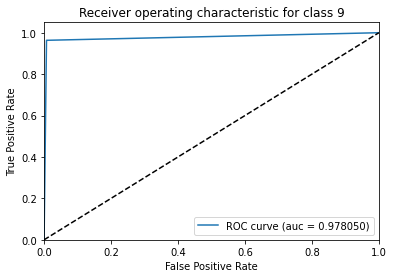

<ipython-input-11-9195afd42829>:49: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


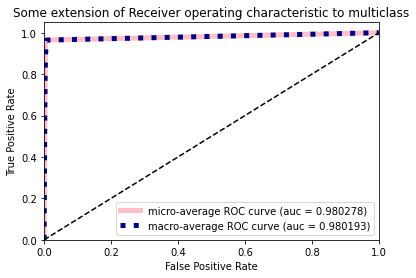

In [28]:
test(model8, test_loader, 'cross-entropy')   

## Sigmoid, CE, RMSProp

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (activation): Sigmoid()
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 0
loss: 2.416061  [   64/60000]
loss: 0.660757  [19264/60000]
loss: 0.372562  [38464/60000]
loss: 0.254230  [57664/60000]
epoch loss: 0.7480
epoch accuracy: 75.1733
*************************
Epoch 1
loss: 0.170879  [   64/60000]
loss: 0.282241  [19264/60000]
loss: 0.128122  [38464/60000]
loss: 0.317082  [57664/60000]
epoch loss: 0.1864
epoch accuracy: 94.7350
*************************
Epoch 2
loss: 0.115423  [   64/60000]
loss: 0.217323  [19264/60000]
loss: 0.111864  [38464/60000]
loss: 0.205148  [57664/60000]
epoch loss: 0.1403
epoch accuracy: 95.9967
*************************
Epoch 3
loss: 0.046026  [   64/60000]
loss: 0.208094  [19264/60000]
loss: 0.138032  [38464

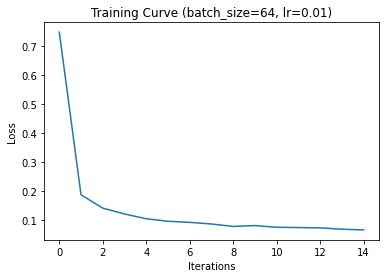

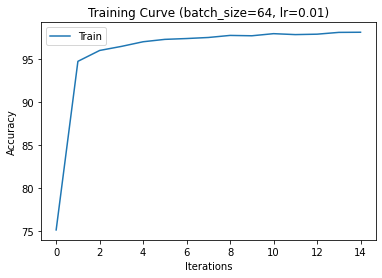

In [29]:
model9 = Net(activation='sigmoid')
print(model9)

losses9, accuracies9 = train(model9, train_loader, 'cross-entropy', 'rms-prop')
plot(losses9, accuracies9)

Test Loss: 0.137099

predictions shape: torch.Size([10000])
test labels shape: torch.Size([10000])
[[7 7]
 [2 2]
 [1 1]
 ...
 [4 4]
 [5 5]
 [6 6]]

Accuracy: 0.9698

confusion matrix:
[[ 963    1    1    0    0    1   11    2    1    0]
 [   0 1124    0    2    0    3    2    1    3    0]
 [   3    6  995   11    3    1    2    5    6    0]
 [   0    0    3  978    1   14    0    5    3    6]
 [   0    1    1    0  967    0    4    1    1    7]
 [   1    0    0    7    1  867    7    3    2    4]
 [   4    2    0    1    4   15  928    1    3    0]
 [   1    6   12    5    3    0    0  989    2   10]
 [   6    1    4    6    9    4    6    4  927    7]
 [   2    3    0    5   31    2    1    3    2  960]]

f1_score for class 0 is: 0.9826530612244898
f1_score for class 1 is: 0.9863975427819218
f1_score for class 2 is: 0.9716796875
f1_score for class 3 is: 0.965925925925926
f1_score for class 4 is: 0.9665167416291854
f1_score for class 5 is: 0.9638688160088937
f1_score for class 6 is: 0.

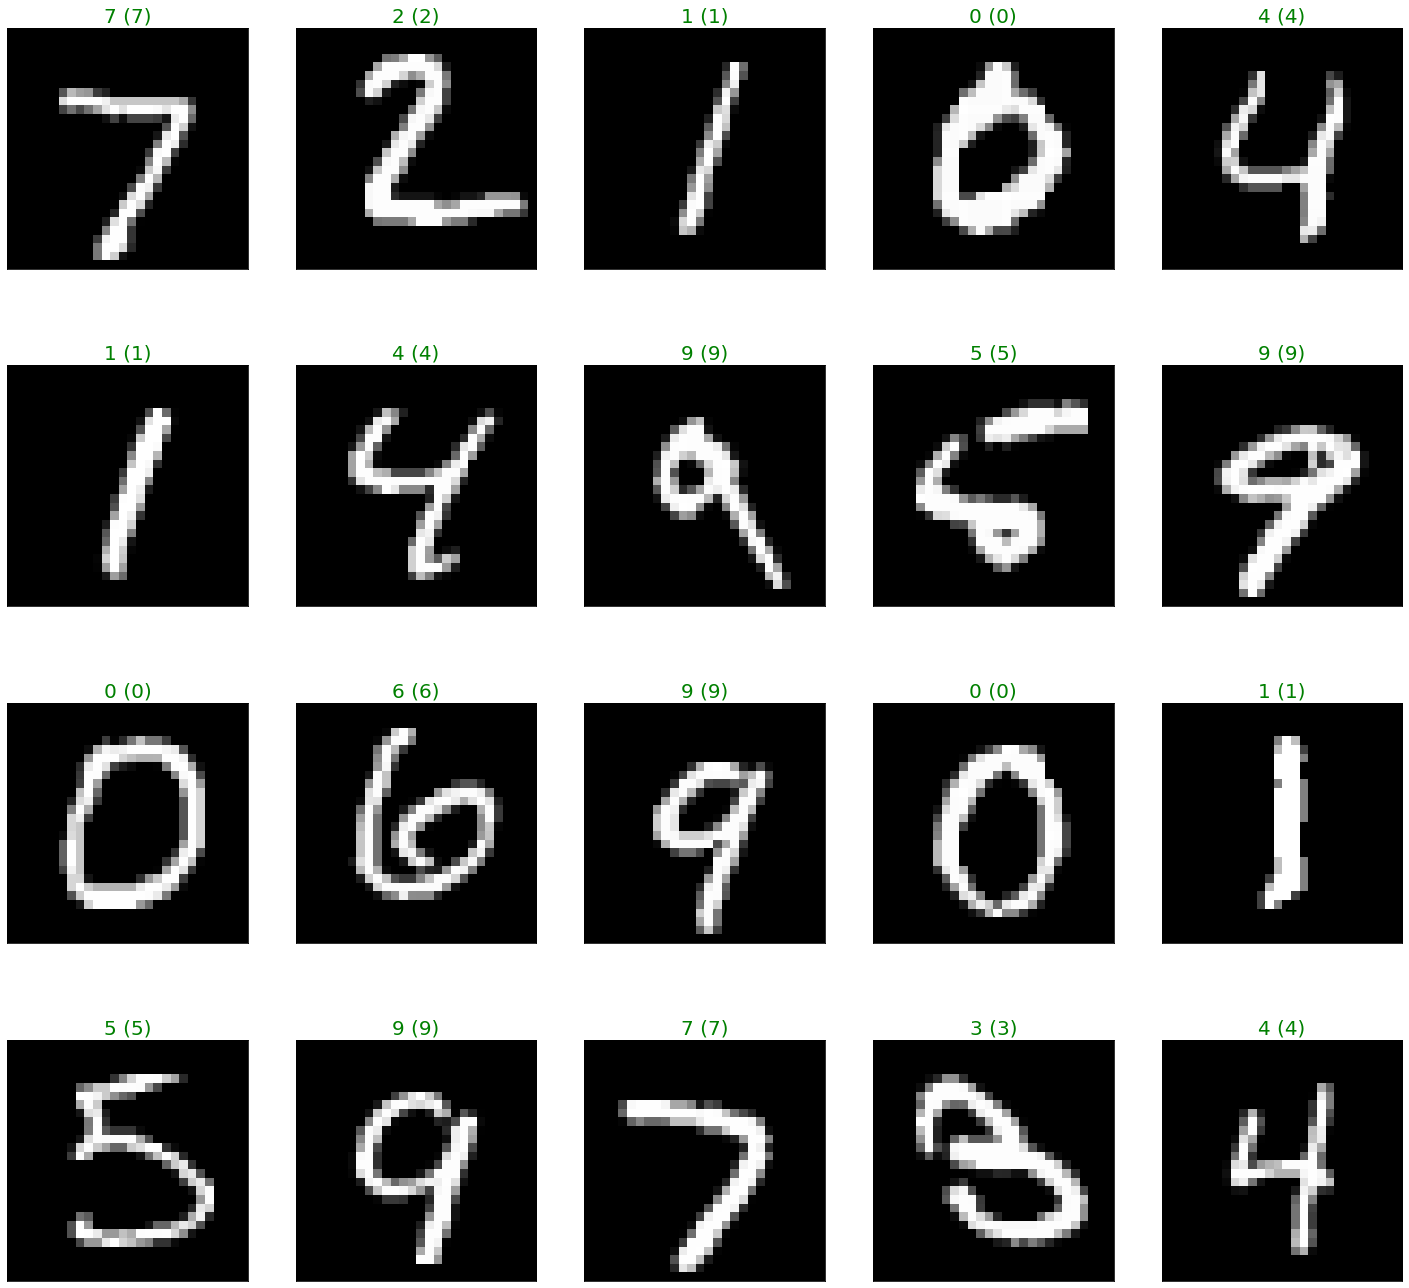

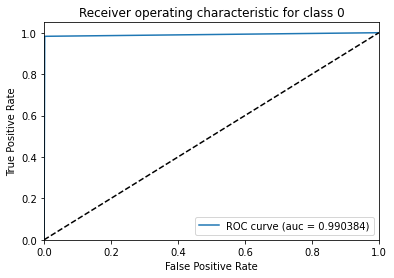

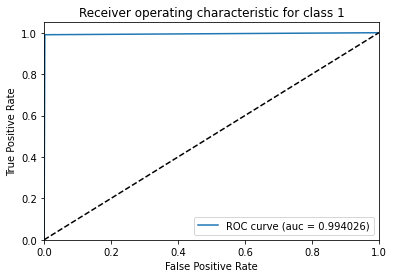

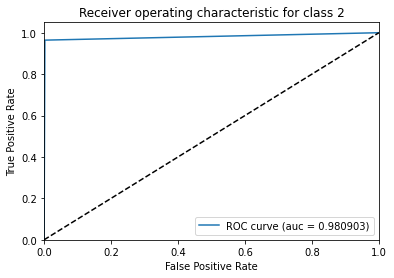

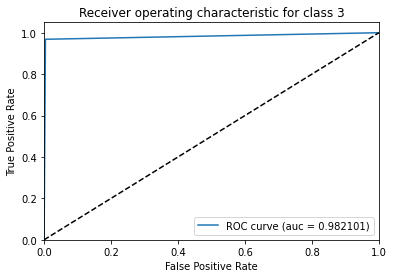

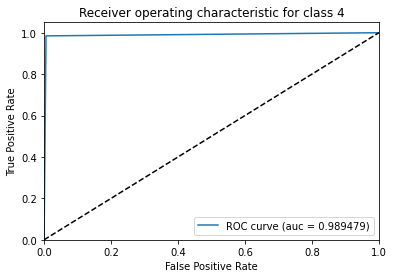

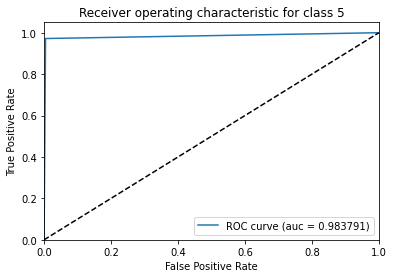

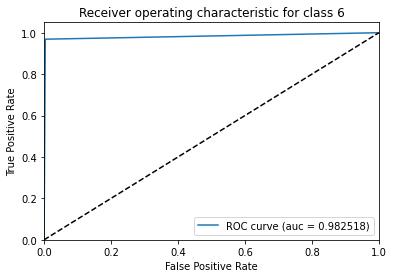

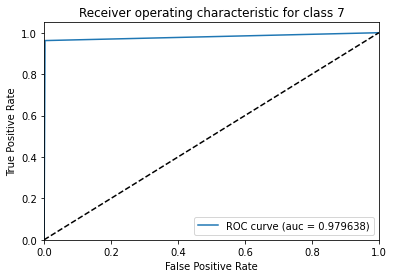

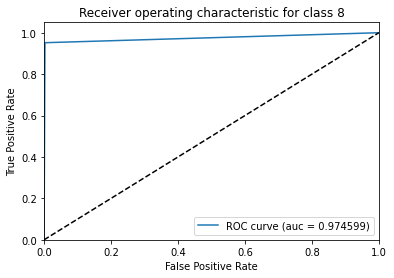

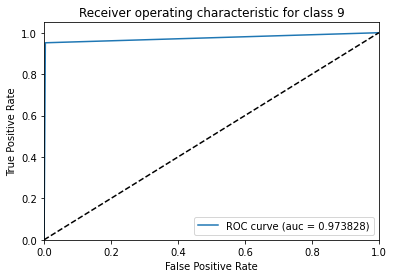

<ipython-input-11-9195afd42829>:49: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


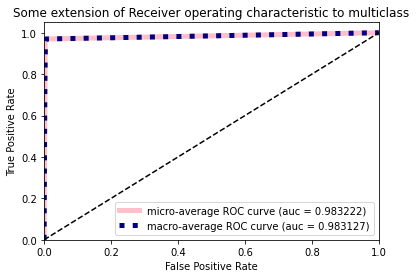

In [30]:
test(model9, test_loader, 'cross-entropy')   

## Sigmoid, NLL, SGD

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (activation): Sigmoid()
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 0
loss: 2.315375  [   64/60000]
loss: 2.298580  [19264/60000]
loss: 2.286319  [38464/60000]
loss: 2.273784  [57664/60000]
epoch loss: 2.3079
epoch accuracy: 10.6433
*************************
Epoch 1
loss: 2.271265  [   64/60000]
loss: 2.301161  [19264/60000]
loss: 2.308747  [38464/60000]
loss: 2.287933  [57664/60000]
epoch loss: 2.2994
epoch accuracy: 11.8167
*************************
Epoch 2
loss: 2.304844  [   64/60000]
loss: 2.288404  [19264/60000]
loss: 2.299475  [38464/60000]
loss: 2.280934  [57664/60000]
epoch loss: 2.2898
epoch accuracy: 13.4050
*************************
Epoch 3
loss: 2.285103  [   64/60000]
loss: 2.277257  [19264/60000]
loss: 2.280590  [38464

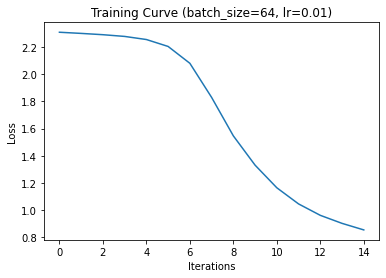

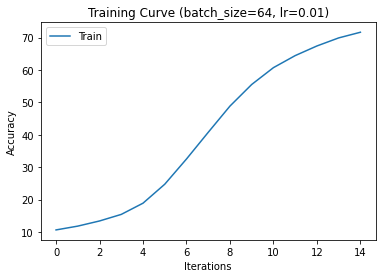

In [31]:
model10 = Net(activation='sigmoid', criterion='nll')
print(model10)

losses10, accuracies10 = train(model10, train_loader, 'nll', 'sgd')
plot(losses10, accuracies10)

Test Loss: 0.814859

predictions shape: torch.Size([10000])
test labels shape: torch.Size([10000])
[[7 7]
 [2 2]
 [1 1]
 ...
 [9 4]
 [5 5]
 [6 6]]

Accuracy: 0.7355

confusion matrix:
[[ 885    0    2   10    2   63   15    1    2    0]
 [   0 1094   14    6    0    0    0    1   18    2]
 [  19   57  712   65   28   20   69    9   46    7]
 [   6   17   38  774    2   59    1   30   77    6]
 [   2    6    2    0  715    0   33   12   17  195]
 [  69    4   33  163   22  452   36   34   61   18]
 [  35    2   58    0   28   17  808    0   10    0]
 [   3   60    5    6    8   13    0  823   22   88]
 [  22   37   72  141   30   73   23   23  526   27]
 [  13    5    1    6  236   13    6  148   15  566]]

f1_score for class 0 is: 0.8702064896755161
f1_score for class 1 is: 0.9052544476623914
f1_score for class 2 is: 0.723209751142712
f1_score for class 3 is: 0.7097661623108666
f1_score for class 4 is: 0.6965416463711641
f1_score for class 5 is: 0.5642946317103621
f1_score for class 6 

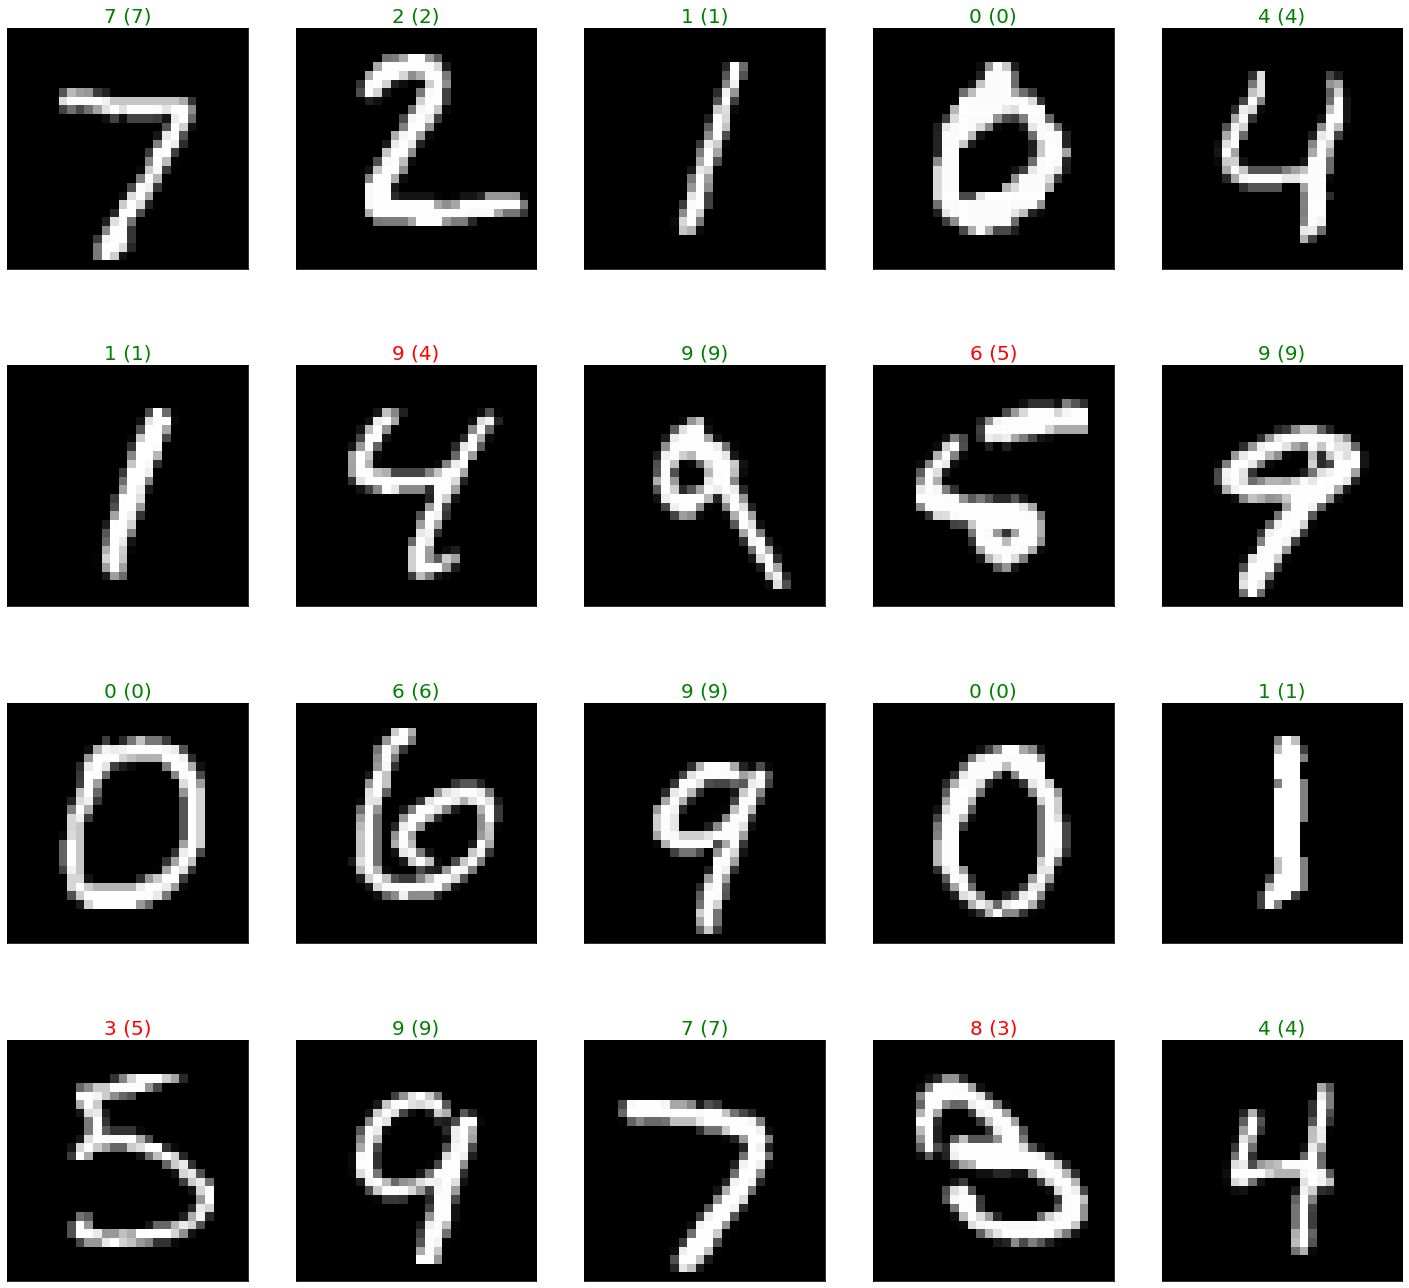

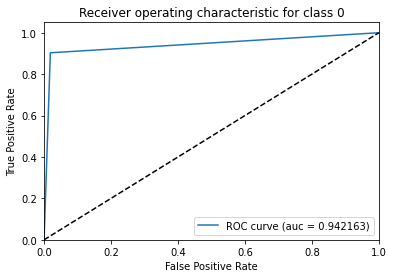

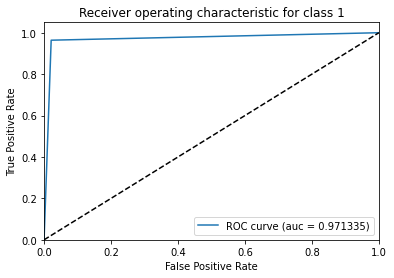

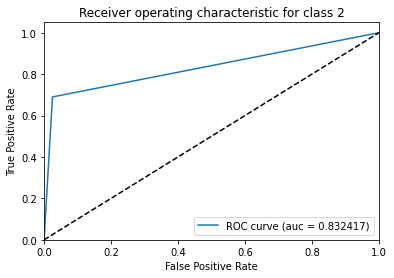

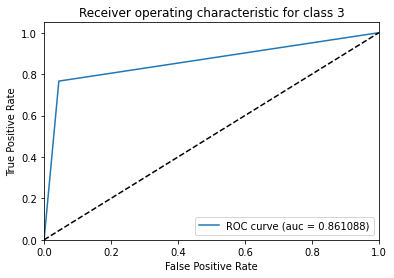

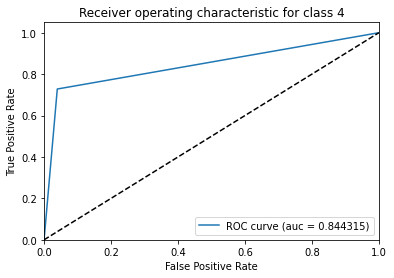

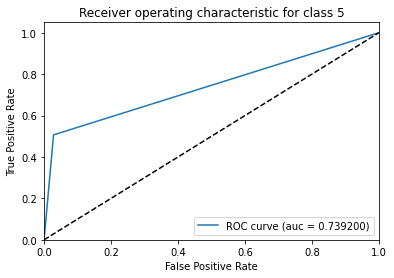

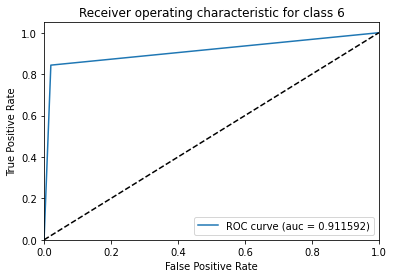

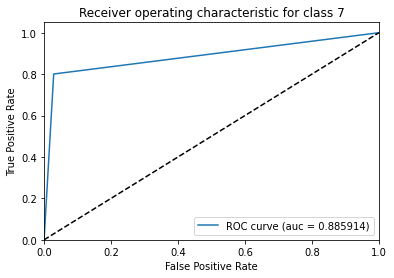

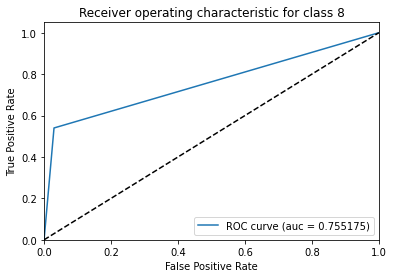

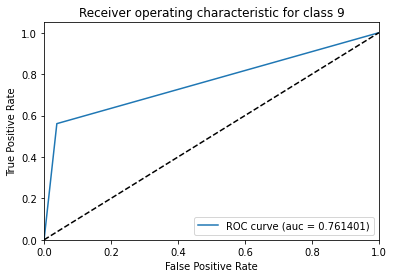

<ipython-input-11-9195afd42829>:49: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


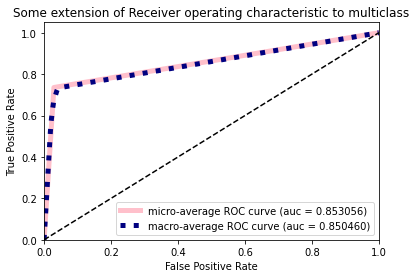

In [32]:
test(model10, test_loader, 'sgd')   

In [2]:
test_accs = [("ReLU, NLL, SGD", 0.9507), 
             ("ReLU, NLL, RMSProp", 0.9493),
             ("ReLU, CE, Adam", 0.9505),
             ("ReLU, CE, SGD", 0.9496),
             ("Tanh, CE, SGD", 0.9116),
             ("Tanh, NLL, SGD", 0.9279),
             ("Tanh, NLL, RMSProp", 0.9118),
             ("Sigmoid, CE, Adam", 0.9645),
             ("Sigmoid, CE, RMSProp", 0.9698),
             ("Sigmoid, NLL, SGD", 0.7355)]

test_accs.sort(key=lambda x: x[1], reverse=True)             
for t in test_accs:
    print(t)

('Sigmoid, CE, RMSProp', 0.9698)
('Sigmoid, CE, Adam', 0.9645)
('ReLU, NLL, SGD', 0.9507)
('ReLU, CE, Adam', 0.9505)
('ReLU, CE, SGD', 0.9496)
('ReLU, NLL, RMSProp', 0.9493)
('Tanh, NLL, SGD', 0.9279)
('Tanh, NLL, RMSProp', 0.9118)
('Tanh, CE, SGD', 0.9116)
('Sigmoid, NLL, SGD', 0.7355)
